# Project 4 West-Nile Virus Prediction

This is the second Notebook for project 4. It contains sections on:

### Contents:
- [Data Import](#Data-Import)
- [Exploratory Data Analysis - Individual datasets](#Exploratory-Data-Analysis-Individual-Datasets)
- [Pre Processing](#Pre-Processing)
- [Exploratory Data Analysis - Combined](#Exploratory-Data-Analysis-Combined-Datasets)
- [Heatmap / Trap Locations](#Heatmap-/-Trap-Locations)
- [Trap-Analysis-(Identify-Hotspots)](#Trap-Analysis-(Identify-Hotspots))
- [Investigate Top Hotspot (Trap T900 on weather variables)](#Investigate-Top-Hotspot-(Trap-T900-on-weather-variables))
- [Boxplot of Trap T900 weather readings](#Boxplot-of-Trap-T900-weather-readings)
- [Feature Engineering](#Feature-Engineering)


In [1]:
# Import libraries

In [2]:
import pandas as pd
import numpy as np
from time import perf_counter 
from sklearn.neighbors import KernelDensity

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set_style('whitegrid')

#settings to see all columns / rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Import

In [3]:
#import in cleaned files from Notebook 1
df_train   = pd.read_pickle('../assets/train_clean.pkl')
df_test    = pd.read_pickle('../assets/test_clean.pkl')
df_weather = pd.read_pickle('../assets/weather_clean.pkl')
df_spray   = pd.read_pickle('../assets/spray_clean.pkl')
df_traps   = pd.read_pickle('../assets/train_clean.pkl')[['Date', 'Trap', 'Longitude', 'Latitude', 'WnvPresent']]

In [4]:
df_train.shape, df_test.shape, df_weather.shape, df_spray.shape, df_traps.shape

((10506, 9), (116293, 8), (2944, 22), (14835, 4), (10506, 5))

# Exploratory Data Analysis-Individual Datasets

In [5]:
#check the time period of our datasets. 
print('Lists of Yearly and Monthly data availability as in train dataset')
print( "\tYears :", df_train['Date'].dt.year.unique(), "\t\t\t\t Months :", df_train['Date'].dt.month.unique())

print('Lists of Yearly and Monthly data availability as in test dataset')
print( "\tYears :", df_test['Date'].dt.year.unique(), "\t\t\t\t Months :", df_test['Date'].dt.month.unique())

print('Lists of Yearly and Monthly data availability as in weather dataset')
print( "\tYears :", df_weather['Date'].dt.year.unique(), "\t Months :", df_weather['Date'].dt.month.unique())

print('Lists of Yearly and Monthly data availability as in spray dataset')
print( "\tYears :", df_spray['Date'].dt.year.unique(), "\t\t\t\t\t Months :", df_spray['Date'].dt.month.unique())

Lists of Yearly and Monthly data availability as in train dataset
	Years : [2007 2009 2011 2013] 				 Months : [ 5  6  7  8  9 10]
Lists of Yearly and Monthly data availability as in test dataset
	Years : [2008 2010 2012 2014] 				 Months : [ 6  7  8  9 10]
Lists of Yearly and Monthly data availability as in weather dataset
	Years : [2007 2008 2009 2010 2011 2012 2013 2014] 	 Months : [ 5  6  7  8  9 10]
Lists of Yearly and Monthly data availability as in spray dataset
	Years : [2011 2013] 					 Months : [8 9 7]


The test dataset does not have data for May Month. Lets analyse training data for Month of May compared to other months.

In [6]:
# # From Date Column, Create Columns for Year, Month
df_train['Year']  = df_train['Date'].dt.year
df_train['Month'] = df_train['Date'].dt.month

print("Percentage of May month data compared to data for : ")
print("\t\t\t\t   Months Jun-Oct : ",(len(df_train[df_train.Month==5])/len(df_train[df_train.Month!=5]))*100)
print("\t\t\t\t   Month of Jun   : ",(len(df_train[df_train.Month==5])/len(df_train[df_train.Month==6]))*100)
print("\t\t\t\t   Month of Jul   : ",(len(df_train[df_train.Month==5])/len(df_train[df_train.Month==7]))*100)
print("\t\t\t\t   Month of Aug   : ",(len(df_train[df_train.Month==5])/len(df_train[df_train.Month==8]))*100)
print("\t\t\t\t   Month of Sep   : ",(len(df_train[df_train.Month==5])/len(df_train[df_train.Month==9]))*100)
print("\t\t\t\t   Month of Oct   : ",(len(df_train[df_train.Month==5])/len(df_train[df_train.Month==10]))*100)

Percentage of May month data compared to data for : 
				   Months Jun-Oct :  0.8059873344847437
				   Month of Jun   :  5.346912794398472
				   Month of Jul   :  3.2233307751343054
				   Month of Aug   :  2.2394028259130896
				   Month of Sep   :  3.787195671776375
				   Month of Oct   :  30.434782608695656


As the training data for month of May is not very significant to data for any other month except October, we can consider potentially dropping it during modelling.

In [7]:
display(df_weather.sort_values(by='Date').head(1))
display(df_weather.sort_values(by='Date').tail(1))

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  \
0        1 2007-05-01    83    50    67      14        51       56     0   

   Cool Sunrise Sunset  CodeSum  Depth  Water1  SnowFall  PrecipTotal  \
0     2    0448   1849  No Sign      0       0       0.0          0.0   

   StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
0         29.1     29.82          1.7         27       9.2

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  \
2943        2 2014-10-31    49    34    42      -6        29       36    23   

      Cool Sunrise Sunset   CodeSum  Depth  Water1  SnowFall  PrecipTotal  \
2943     0    0623   1647  RA SN BR      0       0       0.0         0.04   

      StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
2943        29.54      30.2         21.7         34      22.6

In [8]:
display(df_train.sort_values(by='Date').head(1))
display(df_train.sort_values(by='Date').tail(1))

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Trap  Latitude  Longitude  AddressAccuracy  \
0  CULEX PIPIENS/RESTUANS  T002  41.95469 -87.800991                9   

   NumMosquitos  WnvPresent  Year  Month  
0             1           0  2007      5

Date                                        Address  \
10505 2013-09-26  4200 West 65th Street, Chicago, IL 60621, USA   

                      Species  Trap   Latitude  Longitude  AddressAccuracy  \
10505  CULEX PIPIENS/RESTUANS  T235  41.776428 -87.627096                8   

       NumMosquitos  WnvPresent  Year  Month  
10505             1           0  2013      9

In [9]:
display(df_test.sort_values(by='Date').head(1))
display(df_test.sort_values(by='Date').tail(1))

Id       Date                                            Address  \
0   1 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Trap  Latitude  Longitude  AddressAccuracy  
0  CULEX PIPIENS/RESTUANS  T002  41.95469 -87.800991                9

Id       Date                                          Address  \
116292  116293 2014-10-02  2100 North Cannon Drive, Chicago, IL 60614, USA   

                Species   Trap   Latitude  Longitude  AddressAccuracy  
116292  CULEX ERRATICUS  T054C  41.925652  -87.63359                8

In [10]:
display(df_spray.sort_values(by='Date').head(1))
display(df_spray.sort_values(by='Date').tail(1))

Date      Time   Latitude  Longitude
0 2011-08-29  18:56:58  42.391623 -88.089163

Date      Time   Latitude  Longitude
14834 2013-09-05  20:35:41  42.004805  -87.81746

In [11]:
df_spray['Date'].nunique()

10

Spraying was carried out on 10 unique dates

In [12]:
# For each spray date, multiple locations were sprayed
df_spray.groupby('Date').count()

Time  Latitude  Longitude
Date                                 
2011-08-29    95        95         95
2011-09-07  2114      2114       2114
2013-07-17  2202      2202       2202
2013-07-25  1607      1607       1607
2013-08-08  1195      1195       1195
2013-08-15  2668      2668       2668
2013-08-16   141       141        141
2013-08-22  1587      1587       1587
2013-08-29  2302      2302       2302
2013-09-05   924       924        924

### Summary of the timelines across the data sets

- The data in the datasets is availble for following periods
    - 1) Weather: 2007-05-01 to 2014-10-31
    - 2) Spray  : 2011-08-29 to 2013-09-05
    - 3) Train  : 2007-05-29 to 2013-09-26
    - 4) Test   : 2008-06-11 to 2014-10-02

- Spraying took place on 10 seperate days in 2011 & 2013. 
    - There are No records of spraying on the days in Test data (Months: 6-10 for Years: 2008,2010,2012,2014)
    - Our predictions for Test data will not consider spraying (100% based on weather data only as Weather data is available for all Test data.
    
- To get important weather features for the model, We will need to Check effects of weather on west nile virus (WNV) by considering the period(2007-05-29 to 2011-08-29) before spraying started on 2011-08-29.

In [13]:
#Columns/Features in train dataset that are not available in test data (This helps to identify target)
set(df_train) - set(df_test)

{'Month', 'NumMosquitos', 'WnvPresent', 'Year'}

Following columns are not found in test dataset
 - 'NumMosquitos'
 - 'WnvPresent'

NumMosquitos will still be used for Analysis as it will help us get insights of mosquito traps in an area. However, As our target is to predict WnvPresent (presence of virus), we will drop NumMosquitos during modeling.

In [14]:
df_train.columns

Index(['Date', 'Address', 'Species', 'Trap', 'Latitude', 'Longitude',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Year', 'Month'],
      dtype='object')

In [15]:
df_test.columns

Index(['Id', 'Date', 'Address', 'Species', 'Trap', 'Latitude', 'Longitude',
       'AddressAccuracy'],
      dtype='object')

Text(0, 0.5, 'Month of training data collected')

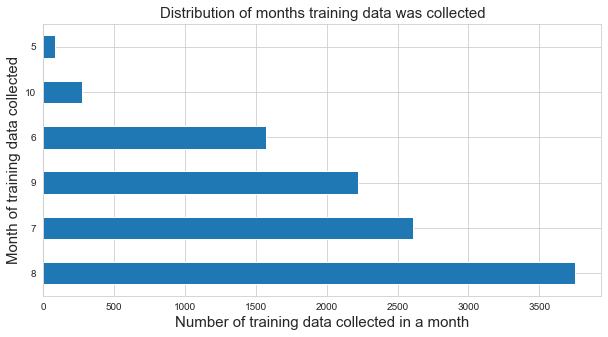

In [16]:
# plot distribution of data collected in a month
plt.figure(figsize = (10,5))
df_train['Month'].value_counts().plot(kind='barh',)
plt.title('Distribution of months training data was collected',{'size': 15})
plt.xlabel('Number of training data collected in a month', {'size': 15})
plt.ylabel('Month of training data collected', {'size': 15})

The bulk of the training data was collected between 6th to 9th month of the year with most data collected in month 8 followed by month 7. This aligns with rainy season in Chicago with wettest [August normal 4.9 inches](https://www.weather.gov/lot/August_Precip_Rankings_Chicago) followed by  [July normal 3.7](https://www.weather.gov/lot/July_Precip_Rankings_Chicago) and [September normal 3.21](https://www.weather.gov/lot/September_Precip_Rankings_Chicago)

Text(0, 0.5, 'Number of West Nile Virus detections')

<Figure size 720x360 with 0 Axes>

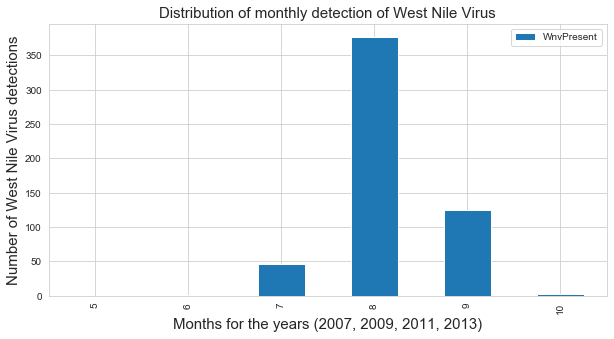

In [17]:
# plot distribution of data collected in a month
plt.figure(figsize = (10,5))
df_train[['Month', 'WnvPresent']].groupby('Month').sum().plot.bar(figsize=(10,5))
plt.title('Distribution of monthly detection of West Nile Virus',{'size': 15})
plt.xlabel('Months for the years (2007, 2009, 2011, 2013)', {'size': 15})
plt.ylabel('Number of West Nile Virus detections', {'size': 15})

Most of the West Nile Virus detections are in the wettest month of August

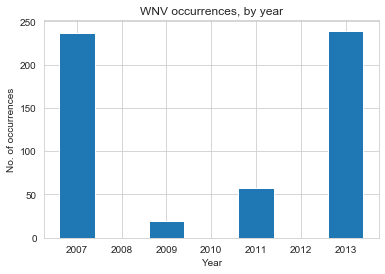

In [18]:
# no. of occurrences, by year
plt.bar(df_train[['Year','WnvPresent']].groupby('Year').sum().index,
        df_train[['Year','WnvPresent']].groupby('Year').sum().WnvPresent)
plt.title('WNV occurrences, by year')
plt.xlabel('Year')
plt.ylabel('No. of occurrences');

Year 2007 and 2013 recorded Most of the WNV occurences (200+). 
- There are relatively less occurences in 2011 (50+) and Year 2009 had minimal occurencess (20+)
- There was no data for year 2008, 2010, 2012 (Training data is available for years 2007, 2009, 2011 and 2013 only)

Are there some species which tend to be correlated with WNV occurrences?

In [19]:
df_train.Species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [20]:
df_test.Species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

Text(0, 0.5, 'West Nile Virus detections')

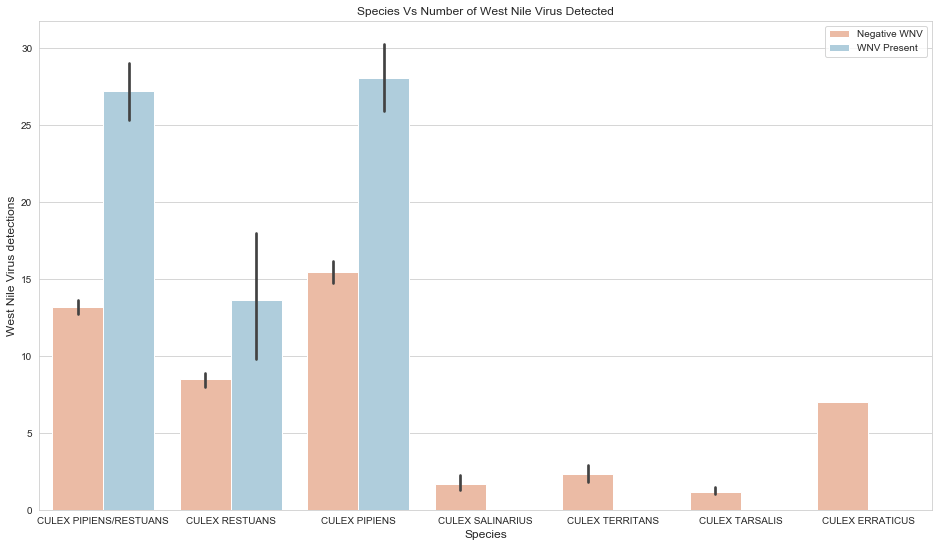

In [21]:
# species of west nile
plt.figure(figsize=(16,9))
ax=sns.barplot(x='Species', y='NumMosquitos', hue='WnvPresent',data=df_train,palette="RdBu")
plt.title("Species Vs Number of West Nile Virus Detected", fontsize='large')
L = plt.legend(loc="upper right")
L.get_texts()[0].set_text('Negative WNV')
L.get_texts()[1].set_text('WNV Present')
plt.xlabel("Species", fontsize ='large')
plt.ylabel("West Nile Virus detections", fontsize='large')

- From above plots visualization, it apears that

 - Only Culex Pipiens and Culex Restuans tested positive for West Nile Virus. Culex Pipiens/Restuans are traps which caught both Culex Pipiens and Culex Restuans.
 - It is clear to deduce that only Culex Pipiens and Culex Restuans are carriers of the disease
 - As Virus-Carrying species are Culex Pipiens and Culex Restuans, it gives a complexing reason to group together Culex Pipiens and Culex Restuans with Culex Pipiens/Restuans as Virus-Carrying, and all other species as Non-Virus-Carrying


However, upon further analysis using a reference check on [Center for Disease Control and Prevention](https://www.cdc.gov/westnile/resources/pdfs/MosquitoSpecies1999-2016.pdf), a government organisation, provided a list updated on 2016 which shows that known carriers also include the other species caught.

Another organisation, [Vector Disease Control International](http://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health) providing Mosquito Management Services listed 3 species, Culex pipiens, Culex tarsalis, and Culex quinquefasciatus as carriers.

Due to conflicting information we shall include all species in our model.

If it is determined that other species caught are still carriers, we can infer that it is coincidental that only Culex Pipiens and Culex Restuans are carriers and we should still consider the rest of the species as a feature.

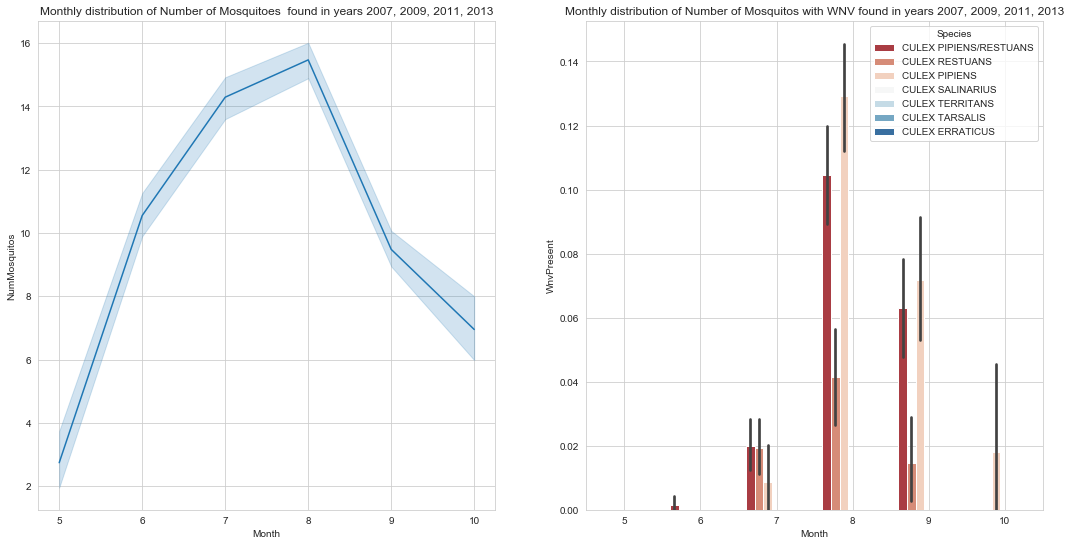

In [22]:
f,ax=plt.subplots(1,2,figsize=(18,9))
#Months Vs Number of Mosquitoes(NumMosquitos)
ax[0].set_title('Monthly distribution of Number of Mosquitoes  found in years 2007, 2009, 2011, 2013')
ax[0]=sns.lineplot(x='Month', y='NumMosquitos',data=df_train,ax=ax[0],palette="RdBu")
ax[0].grid(b = True)

#Months Vs WnvPresent
ax[1].set_title('Monthly distribution of Number of Mosquitos with WNV found in years 2007, 2009, 2011, 2013')
ax[1]=sns.barplot(x='Month', y='WnvPresent',hue='Species',data=df_train,palette="RdBu",ax=ax[1])
ax[1].grid(b = True)

Over Years of 2007, 2009, 2011, 2013 the highest total number of WNV detections were observed in the month of August(wettest month). And carrier species number also high in wet season of the year.

In addition, over years of 2007, 2009, 2011, 2013 the highest number of mosquitos were observed on the month of August(wettest month) with steady increase from month of May then decreased after month of August. Carrier species  with WNV detection also followed same trend as number of mosquito.

Please refer below to plots of Monthly averages of data (as in above two plots) for each year

    Year  Month  NumMosquitos
0   2007      5      1.600000
1   2007      6      2.431818
2   2007      7     12.520000
3   2007      8     19.519512
4   2007      9     12.015504
5   2007     10      8.085308
6   2009      5      3.220339
7   2009      6     12.785467
8   2009      7     11.699338
9   2009      8      6.272727
10  2009      9      5.112440
11  2009     10      3.261538
12  2011      6     10.627297
13  2011      7     13.195312
14  2011      8      6.020284
15  2011      9      6.179630
16  2013      6     10.805046
17  2013      7     20.080189
18  2013      8     15.236211
19  2013      9     12.870370
    Month                 Species  NumMosquitos
0       5           CULEX PIPIENS      1.000000
1       5  CULEX PIPIENS/RESTUANS      2.714286
2       5          CULEX RESTUANS      2.947368
3       6           CULEX PIPIENS      3.074074
4       6  CULEX PIPIENS/RESTUANS     13.174716
5       6          CULEX RESTUANS      9.355705
6       6        CULEX SALINARIUS 

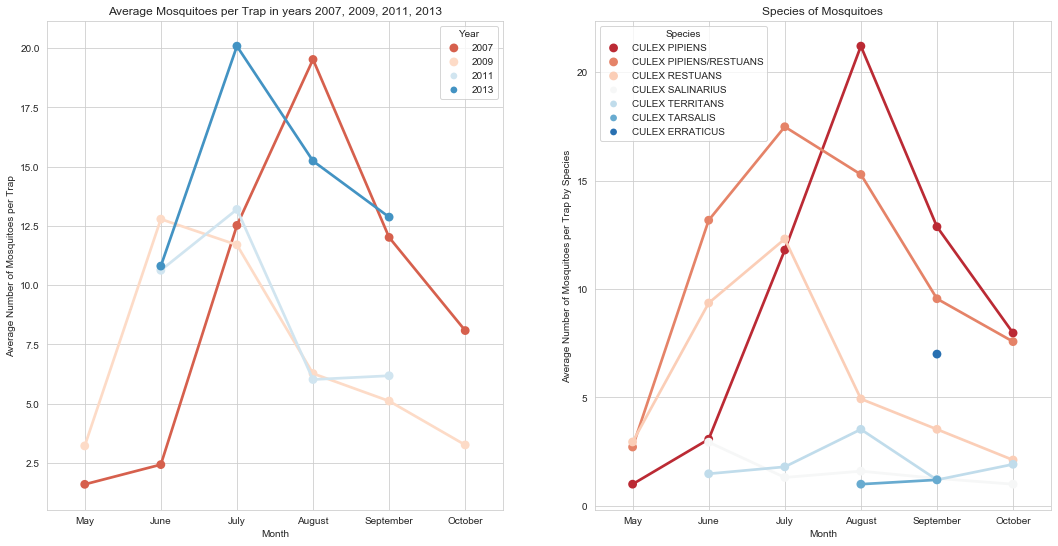

In [23]:
#Average number of mosquitoes caught monthly in years 2007, 2009, 2011, 2013
avg_mosquitoes_trap_month = df_train.groupby(['Year','Month'],as_index=False)['NumMosquitos'].mean()
print(avg_mosquitoes_trap_month)

#Average number of mosquitoes caught by species monthly in years 2007, 2009, 2011, 2013
avg_mosquitoes_trap = df_train.groupby(['Month', 'Species'],as_index=False)['NumMosquitos'].mean()
print(avg_mosquitoes_trap)

#fig, ax = plt.subplots(figsize=(10,7))
f,ax=plt.subplots(1,2,figsize=(18,9))

#Plot Average number of mosquitoes caught monthly in years 2007, 2009, 2011, 2013
ax[0] = sns.pointplot(x='Month', y="NumMosquitos", hue='Year', data=avg_mosquitoes_trap_month,ax=ax[0],palette="RdBu");
ax[0].set_xticklabels(labels=['May', 'June', 'July', 'August', 'September', 'October'])
ax[0].set_title('Average Mosquitoes per Trap in years 2007, 2009, 2011, 2013')
ax[0].set_ylabel('Average Number of Mosquitoes per Trap')
#ax[0].set_yticklabels('Average Number of Mosquitoes per Trap')
ax[0].grid(b = True)

#Plot Average number of mosquitoes caught by species monthly in years 2007, 2009, 2011, 2013
ax[1] = sns.pointplot(x='Month', y="NumMosquitos", hue='Species', data=avg_mosquitoes_trap,ax=ax[1],palette="RdBu");
ax[1].set_xticklabels(labels=['May', 'June', 'July', 'August', 'September', 'October'])
ax[1].set_title('Species of Mosquitoes')
ax[1].set_ylabel('Average Number of Mosquitoes per Trap by Species');
ax[1].grid(b = True)

From the above , we can see that average mosquitoes trapped is high for years which had higher outbreak. There were more cases in 2007 and 2013 compared to years 2009, 2011. Peak period trap every year is around July/August.

The Average number of mosquitoes species carrying virus and getting trapped peaks around Jul/August.

Let's see the distribution of WNV occurrences (top 20, bottom 20)

In [24]:
#based on different addresses, we are trying to find how many WNV positive case at a certain location
mosquitoe_trap_locations=df_train.groupby(['Address', 'Trap'], as_index=False)\
                        ['WnvPresent', 'NumMosquitos'].sum().sort_values('WnvPresent', ascending=False)
mosquitoe_trap_locations.head(20)

Address  Trap  WnvPresent  \
124  ORD Terminal 5, O'Hare International Airport, ...  T900          66   
129                South Doty Avenue, Chicago, IL, USA  T115          41   
60   4100 North Oak Park Avenue, Chicago, IL 60634,...  T002          18   
131        South Stony Island Avenue, Chicago, IL, USA  T138          16   
66       4600 Milwaukee Avenue, Chicago, IL 60630, USA  T003          14   
109  8200 South Kostner Avenue, Chicago, IL 60652, USA  T225          11   
48   3600 North Pittsburgh Avenue, Chicago, IL 6063...  T011          11   
33      2400 East 105th Street, Chicago, IL 60617, USA  T128          11   
87   6100 West Fullerton Avenue, Chicago, IL 60639,...  T013          10   
125            Ohare Court, Bensenville, IL 60106, USA  T903          10   
98   7000 North Moselle Avenue, Chicago, IL 60646, USA  T008          10   
73   5100 North Mont Clare Avenue, Chicago, IL 6065...  T223           9   
75    5200 South Kolmar Avenue, Chicago, IL 60632, USA  T114           9   
81   5800 North Western Avenue, Chicago, IL 60659, USA  T028           9   
56      4000 East 130th Street, Chicago, IL 60633, USA  T221           9   
28      2200 West 113th Street, Chicago, IL 60643, USA  T086           8   
29       2200 West 51st Street, Chicago, IL 60609, USA  T061           8   
1    1000 North Central Park Avenue, Chicago, IL 60...  T030           8   
72     5000 South Union Avenue, Chicago, IL 60609, USA  T082           8   
62        4200 West 127th Street, Alsip, IL 60803, USA  T135           8   

     NumMosquitos  
124         15386  
129         21668  
60           3710  
131          9936  
66           1346  
109          2014  
48           1311  
33           3315  
87           1193  
125          2327  
98           2668  
73           1281  
75           2161  
81           1020  
56           1699  
28           1312  
29            840  
1            1802  
72            892  
62           3122

Top 5 occurrences of WNV are at following traps
 - Trap T900 (O'Hare International Airport) with 66 occurences
 - Trap T115 (South Doty Avenue) with 41 occurences
 - Trap T002 (North Oak Park Avenue) with 18 occurences
 - Trap T138 (South Stony Island Avenue) with 16 occurences
 - Trap T003 (Milwaukee Avenue) with 14 occurences

In [25]:
mosquitoe_trap_locations.head(20)

Address  Trap  WnvPresent  \
124  ORD Terminal 5, O'Hare International Airport, ...  T900          66   
129                South Doty Avenue, Chicago, IL, USA  T115          41   
60   4100 North Oak Park Avenue, Chicago, IL 60634,...  T002          18   
131        South Stony Island Avenue, Chicago, IL, USA  T138          16   
66       4600 Milwaukee Avenue, Chicago, IL 60630, USA  T003          14   
109  8200 South Kostner Avenue, Chicago, IL 60652, USA  T225          11   
48   3600 North Pittsburgh Avenue, Chicago, IL 6063...  T011          11   
33      2400 East 105th Street, Chicago, IL 60617, USA  T128          11   
87   6100 West Fullerton Avenue, Chicago, IL 60639,...  T013          10   
125            Ohare Court, Bensenville, IL 60106, USA  T903          10   
98   7000 North Moselle Avenue, Chicago, IL 60646, USA  T008          10   
73   5100 North Mont Clare Avenue, Chicago, IL 6065...  T223           9   
75    5200 South Kolmar Avenue, Chicago, IL 60632, USA  T114           9   
81   5800 North Western Avenue, Chicago, IL 60659, USA  T028           9   
56      4000 East 130th Street, Chicago, IL 60633, USA  T221           9   
28      2200 West 113th Street, Chicago, IL 60643, USA  T086           8   
29       2200 West 51st Street, Chicago, IL 60609, USA  T061           8   
1    1000 North Central Park Avenue, Chicago, IL 60...  T030           8   
72     5000 South Union Avenue, Chicago, IL 60609, USA  T082           8   
62        4200 West 127th Street, Alsip, IL 60803, USA  T135           8   

     NumMosquitos  
124         15386  
129         21668  
60           3710  
131          9936  
66           1346  
109          2014  
48           1311  
33           3315  
87           1193  
125          2327  
98           2668  
73           1281  
75           2161  
81           1020  
56           1699  
28           1312  
29            840  
1            1802  
72            892  
62           3122

Add a column by calculating the percent of mosquitoes carrying WNV (West Nile Virus)

In [26]:
mosquitoe_trap_locations['percent'] = mosquitoe_trap_locations['WnvPresent'] / mosquitoe_trap_locations['NumMosquitos']
mosquitoe_trap_locations.sort_values(['percent'], ascending=False).head(30)

Address  Trap  WnvPresent  \
84     6000 West Roscoe Street, Chicago, IL 60634, USA  T005           2   
82   6000 North Avondale Avenue, Chicago, IL 60631,...  T006           4   
93   6500 North Oak Park Avenue, Chicago, IL 60631,...  T143           6   
107    7900 West Foster Avenue, Chicago, IL 60656, USA  T015           4   
122                 East 91st Street, Chicago, IL, USA  T107           2   
76   5200 South Nordica Avenue, Chicago, IL 60638, USA  T070           2   
63       4200 West 31st Street, Chicago, IL 60623, USA  T036           1   
57    4000 North Austin Avenue, Chicago, IL 60634, USA  T142           1   
95   6600 South Kilpatrick Avenue, Chicago, IL 6062...  T156           1   
59   4000 South Dearborn Street, Chicago, IL 60609,...  T081           3   
114  9300 South Doctor Martin Luther King Junior Dr...  T162           1   
91   6400 South Stony Island Avenue, Chicago, IL 60...  T077           1   
64       4200 West 65th Street, Chicago, IL 60621, USA  T235           7   
90       6300 West 64th Street, Chicago, IL 60638, USA  T155           6   
92           6400 West Strong Street, Chicago, IL, USA  T014           4   
22      2000 East 111th Street, Chicago, IL 60628, USA  T084           1   
11   1300 North Laramie Avenue, Chicago, IL 60651, USA  T230           7   
133           South Vincennes Avenue, Chicago, IL, USA  T089           4   
24    2100 North Lawler Avenue, Chicago, IL 60639, USA  T154           2   
40     3000 South Hoyne Avenue, Chicago, IL 60608, USA  T035           1   
79     5800 North Pulaski Road, Chicago, IL 60646, USA  T027           7   
66       4600 Milwaukee Avenue, Chicago, IL 60630, USA  T003          14   
31       2200 West 89th Street, Chicago, IL 60643, USA  T096           6   
17     1700 North Pulaski Road, Chicago, IL 60639, USA  T039           4   
29       2200 West 51st Street, Chicago, IL 60609, USA  T061           8   
54   3900 North Springfield Avenue, Chicago, IL 606...  T228           6   
74       5100 West 72nd Street, Chicago, IL 60638, USA  T035           2   
100   7100 North Harlem Avenue, Chicago, IL 60631, USA  T233           7   
72     5000 South Union Avenue, Chicago, IL 60609, USA  T082           8   
81   5800 North Western Avenue, Chicago, IL 60659, USA  T028           9   

     NumMosquitos   percent  
84             50  0.040000  
82            107  0.037383  
93            230  0.026087  
107           169  0.023669  
122            86  0.023256  
76             90  0.022222  
63             52  0.019231  
57             58  0.017241  
95             61  0.016393  
59            207  0.014493  
114            70  0.014286  
91             70  0.014286  
64            557  0.012567  
90            530  0.011321  
92            364  0.010989  
22             91  0.010989  
11            644  0.010870  
133           374  0.010695  
24            188  0.010638  
40             94  0.010638  
79            666  0.010511  
66           1346  0.010401  
31            578  0.010381  
17            404  0.009901  
29            840  0.009524  
54            643  0.009331  
74            215  0.009302  
100           758  0.009235  
72            892  0.008969  
81           1020  0.008824

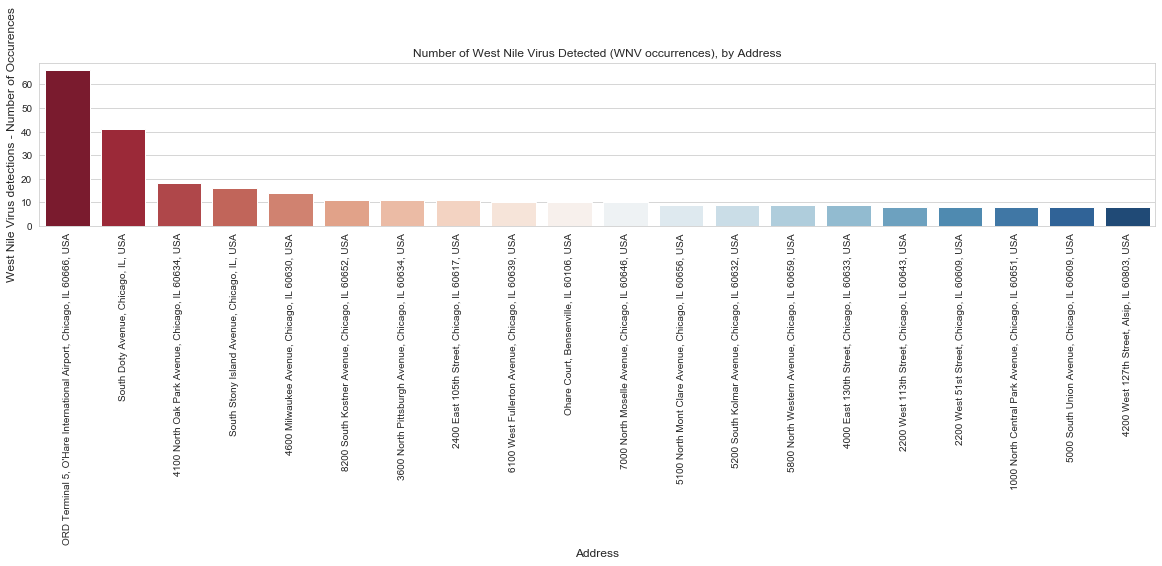

In [27]:
#plot Top20 locations by Address
plt.figure(figsize=(20,3))
plt.xticks(rotation=90)
ax=sns.barplot(x='Address', y='WnvPresent', data=mosquitoe_trap_locations.head(20), palette="RdBu")
#ax=sns.barplot(x='Address', y='NumMosquitos', data=mosquitoe_trap_locations, palette="RdBu")

plt.title('Number of West Nile Virus Detected (WNV occurrences), by Address')
plt.xlabel('Address', fontsize ='large')
plt.ylabel("West Nile Virus detections - Number of Occurences", fontsize='large');

We see that top occurrences of WNV happen near OHare Airport, South Doty Avenue, North Oak Park Avenue etc. Clearly, location matters.

In [28]:
mosquitoe_trap_locations[mosquitoe_trap_locations['WnvPresent'] > 0].tail(20)

Address   Trap  WnvPresent  \
68    4800 West Montana Street, Chicago, IL 60639, USA   T222           1   
57    4000 North Austin Avenue, Chicago, IL 60634, USA   T142           1   
114  9300 South Doctor Martin Luther King Junior Dr...   T162           1   
103         7300 Cicero Avenue, Chicago, IL 60638, USA   T067           1   
101  7100 South South Shore Drive, Chicago, IL 6064...   T079           1   
47       3500 West 51st Street, Chicago, IL 60632, USA   T062           1   
19    1700 West Addison Street, Chicago, IL 60613, USA   T224           1   
97     6800 West Belden Avenue, Chicago, IL 60707, USA   T037           1   
95   6600 South Kilpatrick Avenue, Chicago, IL 6062...   T156           1   
22      2000 East 111th Street, Chicago, IL 60628, USA   T084           1   
23     2100 North Cannon Drive, Chicago, IL 60614, USA  T054C           1   
91   6400 South Stony Island Avenue, Chicago, IL 60...   T077           1   
3        1000 West 95th Street, Chicago, IL 60643, USA   T085           1   
120        East 138th Street, Riverdale, IL 60827, USA   T097           1   
132            South Torrence Avenue, Chicago, IL, USA   T200           1   
30       2200 West 69th Street, Chicago, IL 60636, USA   T069           1   
89   6200 North Mcclellan Avenue, Chicago, IL 60646...   T236           1   
63       4200 West 31st Street, Chicago, IL 60623, USA   T036           1   
9     1100 West Chicago Avenue, Chicago, IL 60642, USA   T049           1   
119                                   Chicago, IL, USA   T145           1   

     NumMosquitos   percent  
68            300  0.003333  
57             58  0.017241  
114            70  0.014286  
103           197  0.005076  
101           335  0.002985  
47            623  0.001605  
19            284  0.003521  
97            171  0.005848  
95             61  0.016393  
22             91  0.010989  
23            145  0.006897  
91             70  0.014286  
3             185  0.005405  
120           129  0.007752  
132          1368  0.000731  
30            439  0.002278  
89            375  0.002667  
63             52  0.019231  
9             260  0.003846  
119           402  0.002488

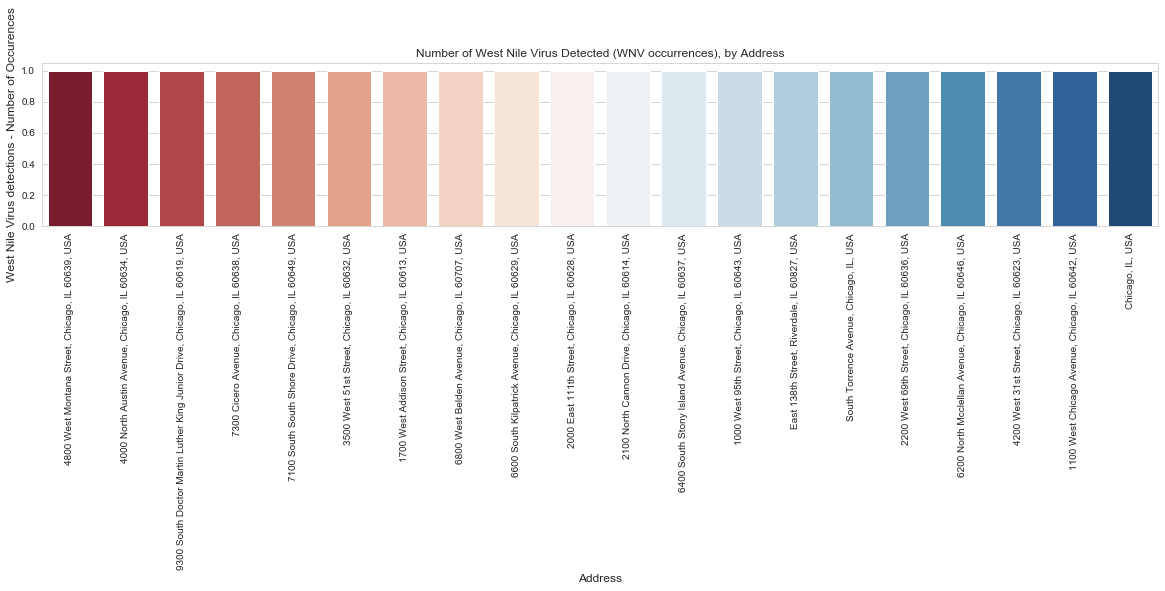

In [29]:
#plot Bottom 20 locations with WnvPresent by Address
plt.figure(figsize=(20,3))
plt.xticks(rotation=90)
ax=sns.barplot(x='Address', 
               y='WnvPresent', 
               data=mosquitoe_trap_locations[mosquitoe_trap_locations['WnvPresent'] > 0].tail(20), 
               palette="RdBu")
#ax=sns.barplot(x='Address', y='NumMosquitos', data=mosquitoe_trap_locations, palette="RdBu")

plt.title('Number of West Nile Virus Detected (WNV occurrences), by Address')
plt.xlabel('Address', fontsize ='large')
plt.ylabel("West Nile Virus detections - Number of Occurences", fontsize='large');

We see that lowest occurrences of WNV happen near East 111th Street, North Cannon Drive, South Stony Island Avenue etc. Clearly, location matters. 

But herein lies the problem: there are some addresses in test, that are not found in train (we check below). 

In [30]:
# check that indeed not all addresses that are found in train, can be found in test
print('No of unique AddressNumberAndStreet in train:',len(df_train.Address.unique()))
print('No of unique AddressNumberAndStreet in test:',len(df_test.Address.unique()))

No of unique AddressNumberAndStreet in train: 138
No of unique AddressNumberAndStreet in test: 151


We hence cannot use Address (nor its related features eg. Street, Address, AddressNumberAndStreet) as a feature. Because if train lacks those features, then how can we fit on train with limited features, then score on test which has more comprehensive features

In [31]:
# Check the correlation of all independent variables with WnvPresent
df_train.corr()['WnvPresent'].sort_values()

Longitude         -0.060345
AddressAccuracy    0.008064
Latitude           0.028697
Year               0.050865
Month              0.100143
NumMosquitos       0.196820
WnvPresent         1.000000
Name: WnvPresent, dtype: float64

In [32]:
# df_test.head(2)

### Explore Weather Dataset

In [33]:
df_weather.head()

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  \
0        1 2007-05-01    83    50    67      14        51       56     0   
1        2 2007-05-01    84    52    68      14        51       57     0   
2        1 2007-05-02    59    42    51      -3        42       47    14   
3        2 2007-05-02    60    43    52      -3        42       47    13   
4        1 2007-05-03    66    46    56       2        40       48     9   

   Cool Sunrise Sunset  CodeSum  Depth  Water1  SnowFall  PrecipTotal  \
0     2    0448   1849  No Sign      0       0       0.0          0.0   
1     3    0448   1849  No Sign      0       0       0.0          0.0   
2     0    0447   1850       BR      0       0       0.0          0.0   
3     0    0447   1850    BR HZ      0       0       0.0          0.0   
4     0    0446   1851  No Sign      0       0       0.0          0.0   

   StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
0        29.10     29.82          1.7         27       9.2  
1        29.18     29.82          2.7         25       9.6  
2        29.38     30.09         13.0          4      13.4  
3        29.44     30.08         13.3          2      13.4  
4        29.39     30.12         11.7          7      11.9

In [34]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null datetime64[ns]
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null int32
Depart         2944 non-null int32
DewPoint       2944 non-null int64
WetBulb        2944 non-null int32
Heat           2944 non-null int32
Cool           2944 non-null int32
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null int64
Water1         2944 non-null int64
SnowFall       2944 non-null float64
PrecipTotal    2944 non-null float64
StnPressure    2944 non-null float64
SeaLevel       2944 non-null float64
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null float64
dtypes: datetime64[ns](1), float64(6), int32(5), int64(7), object(3)
memory usage: 448.6+ KB


In [35]:
df_weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [36]:
df_weather['Station'].unique()

array([1, 2], dtype=int64)

In [37]:
df_weather['Station'].value_counts()

1    1472
2    1472
Name: Station, dtype: int64

Plot HeatMap of correlations within Weather Dataset

(15.0, 0.0)

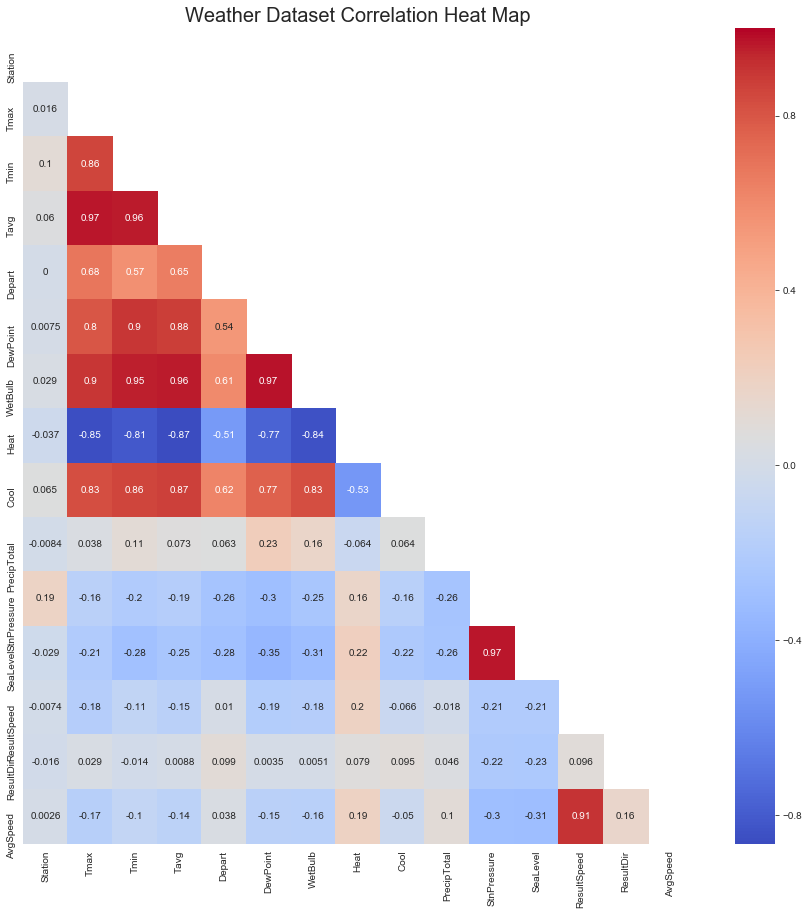

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Weather Dataset Correlation Heat Map', fontsize=20)

mask = np.zeros_like(df_weather[[x for x in df_weather.columns if x not in \
                                    ['Date', 'Water1', 'Depth', 'SnowFall']]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_weather[[x for x in df_weather.columns if x not in \
                           ['Date', 'Water1', 'Depth', 'SnowFall']]].corr(), \
            annot = True, mask = mask, cmap = 'coolwarm') #cmap = 'coolwarm_r', square = True, cbar = False)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Temperature related features 
- Tmax, Tmin, Tavg, Depart, DewPoint, WetBulb are highly correlated to one another. For regression, Tave will be the useful representation of all these temperature data.
- Heat and Cool are also correlated to other temperature variables

ResultSpeed, ResultDir and AvgSpeed relate to wind. As AvgSpeed and ResultSpeed are highly correlated, we can use AvgSpeed and ResultDir.

PrecipTotal will be helpful because max of wnv cases occur in summer months of June/July/Aug/Sep where precipitation is also the high (Highest in August the wettest month)

#### Have a closer look by plotting scatter plot of features that apears to be correlated to confirm observation

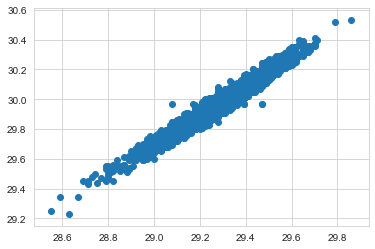

In [39]:
plt.scatter(df_weather['StnPressure'],df_weather['SeaLevel'])

#### StnPressure' (x axis) and 'SeaLevel' (y axis) pressures are closely linearly correlated.

SeaLevel pressure is approximately 0.6 to 0.8 more than StnPressure, since the stations are elevated above sea-level (thus experiencing lower atmospheric pressure). Accordingly, we can estimate that SeaLevel is roughly 0.7 more than StnPressure. Conversely, we can estimate that StnPressure is roughly 0.7 less than SeaLevel. Since both are closely linearly correlated, we can use eitehr one of them for modelling (while the other can be dropped).

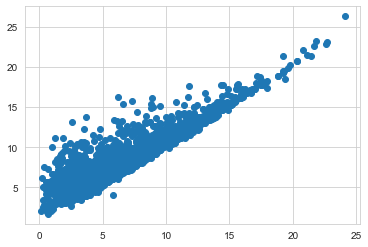

In [40]:
plt.scatter(df_weather['ResultSpeed'],df_weather['AvgSpeed'])

#### 'ResultSpeed' (x axis) and 'AvgSpeed' (y axis) are closely linearly correlated.
Since both are closely linearly correlated, we really only need one of them (the other can be dropped).
Will drop 'AvgSpeed'

In [41]:
# Dewpoint depression = dry bulb temperature(Average Temperature)-dewpoint temperature 
df_weather['DewPointDepression']=df_weather['Tavg']-df_weather['DewPoint']

df_weather.DewPointDepression.unique()

array([16, 17,  9, 10, 18, 22, 21, 29, 30, 24, 28, 13, 19, 23, 25, 26, 27,
       12, 31,  2,  5, 11, 14,  7,  8, 20, 15,  3,  6,  4, -2, 33, 32,  1,
       -1,  0], dtype=int64)

In [42]:
# wet bulb depression = dry bulb temperature(Average Temperature)-wetbulb temperature 
df_weather['WetBulbDepression']=df_weather['Tavg']-df_weather['WetBulb']
df_weather.WetBulbDepression.unique()

array([11,  4,  5,  8, 14, 10, 13,  6,  7,  9, 15, 12, 16, 17,  1,  3,  2,
        0, -5, 19, -2, -1, -4], dtype=int64)

In [43]:
# Function to calculate relative humidity
def relative_humidity(tavg,dewpoint):
    #converted temperature to celcius
    tavg_celcius = (5.0/9.0)*(tavg-32.0)
    dewpoint_celcius = (5.0/9.0)*(dewpoint-32.0)
    # Calculated vapour pressure and actual pressure
    saturation_vapour_pressure = 6.11*10.0**(7.5*tavg_celcius/(237.7+tavg_celcius))
    actual_pressure = 6.11*10.0**(7.5*dewpoint_celcius/(237.7+dewpoint_celcius))
    #return relative humidity
    return round(((actual_pressure/saturation_vapour_pressure)*100))

In [44]:
# New column with Relative humidity values are created from the function
df_weather['RelativeHumidity']=relative_humidity(df_weather['Tavg'],df_weather['DewPoint']).astype(int)
df_weather.RelativeHumidity.unique()

array([ 56,  55,  71,  69,  51,  53,  45,  44,  46,  33,  32,  41,  36,
        70,  63,  50,  54,  49,  42,  39,  40,  38,  64,  61,  37,  35,
        65,  34,  43,  93,  84,  52,  57,  68,  62,  78,  74,  60,  47,
        48,  58,  76,  67,  75,  59,  79,  77,  72,  90,  73,  66,  81,
        83,  87,  82, 107,  80,  86,  89,  85,  30,  96, 104, 100],
      dtype=int64)

In [45]:
df_weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'DewPointDepression',
       'WetBulbDepression', 'RelativeHumidity'],
      dtype='object')

In [46]:
df_weather.CodeSum.unique()

array(['No Sign', 'BR', 'BR HZ', 'HZ', 'RA', 'RA BR', 'TSRA RA BR',
       'RA VCTS', 'TSRA RA', 'RA HZ', 'TSRA RA BR HZ', 'TSRA BR HZ',
       'RA BR HZ VCTS', 'TSRA RA HZ', 'TSRA BR HZ VCTS', 'TSRA',
       'TSRA BR HZ FU', 'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS',
       'HZ VCTS', 'TSRA HZ', 'VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS',
       'TS TSRA RA BR HZ VCTS', 'DZ BR', 'TS TSRA RA BR HZ',
       'TS TSRA BR HZ', 'RA BR HZ', 'TSRA RA DZ BR HZ', 'TS TSRA RA BR',
       'TS RA BR', 'TS TSRA RA', 'TS TSRA RA BR VCTS', 'TS TSRA BR',
       'TS RA', 'RA BCFG BR', 'TSRA BR', 'RA DZ FG+ BCFG BR',
       'RA FG+ MIFG BR', 'RA DZ', 'RA DZ BR', 'TS TSRA RA HZ',
       'TSRA RA FG+ FG BR', 'TSRA DZ FG+ FG BR HZ', 'TS BR', 'RA BR SQ',
       'TS TSRA', 'TSRA RA BR HZ VCTS', 'BR VCTS', 'TS', 'FG+ BR HZ',
       'RA SN', 'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'F

In [47]:
# Extract all the 'CodeSum' component values ('VCTS', 'No', 'TSRA', 'BCFG', 'RA', 'FG', 'GR', 'DZ', 'TS', 'BR'..)

# global variable
list_CodeSum = []

def get_code_sum_elems(str_CodeSum):
    
    global code_sum_list # confirm the use of the global variable in this function
    
    # extend the global variable with this_list
    list_CodeSum.extend(str_CodeSum.split())
    return True

for i in df_weather['CodeSum']:
    get_code_sum_elems(i.strip())
list_CodeSum = list(set(list_CodeSum)) #Retain only unique values
print(list_CodeSum)

['Sign', 'FU', 'HZ', 'RA', 'VCTS', 'SN', 'No', 'DZ', 'VCFG', 'FG+', 'BR', 'TSRA', 'MIFG', 'FG', 'TS', 'GR', 'BCFG', 'SQ']


In [48]:
# #Convert FG+ to FGplus
# list_CodeSum[list_CodeSum.index('FG+')] = 'FGplus'
# print(list_CodeSum)

In [49]:
# For each CodeSum element, create a column (total of 16 columns)
for CodeSumComponent in list_CodeSum:
    df_weather[CodeSumComponent] = 0

In [50]:
#apply the values for the new columns by spliting the codesum
for index, row in df_weather.iterrows():
    cs_list = row['CodeSum'].split() # split the CodeSum string
    for j in cs_list:
        #set corresponding column to 1
        if j in list_CodeSum:
            df_weather.loc[index,j]=1

Test the values for newly added columns for CodeSum components 

In [51]:
#Test the values for newly added columns for CodeSum components 
print(df_weather.Sign.unique())
print(df_weather.VCTS.unique())
print(df_weather.No.unique())
print(df_weather.TSRA.unique())
print(df_weather.RA.unique())
print(df_weather.FG.unique())
print(df_weather.GR.unique())
print(df_weather.DZ.unique())
print(df_weather.TS.unique())
print(df_weather.BR.unique())
print(df_weather['FG+'].unique())
print(df_weather.SN.unique())
print(df_weather.VCFG.unique())
print(df_weather.HZ.unique())
print(df_weather.MIFG.unique())
print(df_weather.SQ.unique())
print(df_weather.FU.unique())

[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [52]:
#check if any missing values
df_weather.isnull().sum()

Station               0
Date                  0
Tmax                  0
Tmin                  0
Tavg                  0
Depart                0
DewPoint              0
WetBulb               0
Heat                  0
Cool                  0
Sunrise               0
Sunset                0
CodeSum               0
Depth                 0
Water1                0
SnowFall              0
PrecipTotal           0
StnPressure           0
SeaLevel              0
ResultSpeed           0
ResultDir             0
AvgSpeed              0
DewPointDepression    0
WetBulbDepression     0
RelativeHumidity      0
Sign                  0
FU                    0
HZ                    0
RA                    0
VCTS                  0
SN                    0
No                    0
DZ                    0
VCFG                  0
FG+                   0
BR                    0
TSRA                  0
MIFG                  0
FG                    0
TS                    0
GR                    0
BCFG            

In [53]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 43 columns):
Station               2944 non-null int64
Date                  2944 non-null datetime64[ns]
Tmax                  2944 non-null int64
Tmin                  2944 non-null int64
Tavg                  2944 non-null int32
Depart                2944 non-null int32
DewPoint              2944 non-null int64
WetBulb               2944 non-null int32
Heat                  2944 non-null int32
Cool                  2944 non-null int32
Sunrise               2944 non-null object
Sunset                2944 non-null object
CodeSum               2944 non-null object
Depth                 2944 non-null int64
Water1                2944 non-null int64
SnowFall              2944 non-null float64
PrecipTotal           2944 non-null float64
StnPressure           2944 non-null float64
SeaLevel              2944 non-null float64
ResultSpeed           2944 non-null float64
ResultDir             2944 non-

In [54]:
# #check for missing values 'M' or NaN
# for c in df_weather.columns:
#     print(c, df_weather[df_weather[c].isin(['M', 'T'])][c].count())

In [55]:
# Drop the 'CodeSum' column as it is not required now as all features are extracted from this.
df_weather.drop(labels='CodeSum',axis=1,inplace=True)

In [56]:
df_weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'Water1',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'DewPointDepression', 'WetBulbDepression',
       'RelativeHumidity', 'Sign', 'FU', 'HZ', 'RA', 'VCTS', 'SN', 'No', 'DZ',
       'VCFG', 'FG+', 'BR', 'TSRA', 'MIFG', 'FG', 'TS', 'GR', 'BCFG', 'SQ'],
      dtype='object')

In [57]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 42 columns):
Station               2944 non-null int64
Date                  2944 non-null datetime64[ns]
Tmax                  2944 non-null int64
Tmin                  2944 non-null int64
Tavg                  2944 non-null int32
Depart                2944 non-null int32
DewPoint              2944 non-null int64
WetBulb               2944 non-null int32
Heat                  2944 non-null int32
Cool                  2944 non-null int32
Sunrise               2944 non-null object
Sunset                2944 non-null object
Depth                 2944 non-null int64
Water1                2944 non-null int64
SnowFall              2944 non-null float64
PrecipTotal           2944 non-null float64
StnPressure           2944 non-null float64
SeaLevel              2944 non-null float64
ResultSpeed           2944 non-null float64
ResultDir             2944 non-null int64
AvgSpeed              2944 non-n

# Pre Processing

In this section, we will calulcate the distance between each trap location and the weather station (1/2) to determine
which station is nearer. We will take the weather data from the nearest station for each train/test observation. 

In [58]:
#This is the function to calculate distance between Geo coordinates
from math import radians, degrees, sin, cos, asin, acos, sqrt
def get_distance_km(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))

In [59]:
#This is the function to calculate distance to station 1 and station 2 based on the longtitude/latitude (input)
#It will return 1 (for station 1) or 2 (for station 2)
def get_nearest_station(long, lat):
    station1_lat = 41.995
    station1_long = -87.933
    station2_lat = 41.786
    station2_long = -87.752
    
    station1_km = get_distance_km(station1_long,station1_lat,long,lat)
    station2_km = get_distance_km(station2_long,station2_lat,long,lat)
    
    if station1_km < station2_km: 
        return 1
    else:
        return 2

In [60]:
#This step is to get the nearest weather station for the observations of training dataset.
#Based on nearest weather station, merge training and weather data to get the corresponding weather readings

#Prepare Train data and Weather Data. Make a copy of train data in train_prep dataframe for further processing


t1_start = perf_counter()
    
df_train_prep = df_train.copy()

t1_stop = perf_counter()  
print("Elapsed time to copy the train data set is {} seconds.".format(t1_stop-t1_start))


#Drop the Year/Date Columns created for Analysis. These will be created again on merged dataset later
df_train_prep.drop(columns=['Year', 'Month'], inplace=True)

t1_start = perf_counter()
for index in df_train_prep.index:    
    df_train_prep.loc[index,'Station'] = get_nearest_station(df_train_prep.loc[index,'Longitude'],
                                                          df_train_prep.loc[index,'Latitude'])

df_train_prep['Station'] = df_train_prep['Station'].astype(int)

t1_stop = perf_counter()  
print("Elapsed time to get and set the station for train dataset {} seconds.".format(t1_stop-t1_start))

df_train_prep['Station'].value_counts()

Elapsed time to copy the train data set is 0.0007578999999964253 seconds.
Elapsed time to get and set the station for train dataset 3.7934237999999993 seconds.


2    7208
1    3298
Name: Station, dtype: int64

In [61]:
#Repeat above step for Test data. Make a copy of test data in test_prep dataframe for further processing

t1_start = perf_counter()
    
df_test_prep = df_test.copy()

t1_stop = perf_counter()  
print("Elapsed time to copy the test data set is {} seconds.".format(t1_stop-t1_start))


t1_start = perf_counter()
for index in df_test_prep.index:
    df_test_prep.loc[index,'Station'] = get_nearest_station(df_test_prep.loc[index,'Longitude'],
                                                         df_test_prep.loc[index,'Latitude'])

df_test_prep['Station'] = df_test_prep['Station'].astype(int)
t1_stop = perf_counter()  
print("Elapsed time to get and set the station for test dataset {} seconds.".format(t1_stop-t1_start))

df_test_prep['Station'].value_counts()

Elapsed time to copy the test data set is 0.005689100000012104 seconds.
Elapsed time to get and set the station for test dataset 140.55110280000002 seconds.


2    80892
1    35401
Name: Station, dtype: int64

Merge train/test with weather based on nearest station

In [62]:
#join train_prep data with weather data on date/station to merge them into the same dataframe
t1_start = perf_counter()

df_train_weather = pd.merge(df_train_prep,df_weather,how='left', on=['Date','Station'])

t1_stop = perf_counter()  
print("Elapsed time to Merge Weather and Train datasets is {} seconds.".format(t1_stop-t1_start))

#add new columns for year,month,week,day for further analysis
t1_start = perf_counter()

df_train_weather['Year']  = df_train_weather['Date'].dt.year
df_train_weather['Month'] = df_train_weather['Date'].dt.month
df_train_weather['Week']  = df_train_weather['Date'].dt.week
df_train_weather['Day']   = df_train_weather['Date'].dt.day

t1_stop = perf_counter()  
print("Elapsed time to convert/add Year/Month/Week/Day from date in train is {} seconds".format(t1_stop-t1_start))

df_train_weather[df_train_weather['Station']==1].head(5)

Elapsed time to Merge Weather and Train datasets is 0.019353899999998703 seconds.
Elapsed time to convert/add Year/Month/Week/Day from date in train is 0.008299700000009125 seconds


Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Trap   Latitude  Longitude  AddressAccuracy  \
0  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991                9   
1          CULEX RESTUANS  T002  41.954690 -87.800991                9   
2          CULEX RESTUANS  T007  41.994991 -87.769279                9   
3  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812                8   
4          CULEX RESTUANS  T015  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  Station  Tmax  Tmin  Tavg  Depart  DewPoint  \
0             1           0        1    88    60    74      10        58   
1             1           0        1    88    60    74      10        58   
2             1           0        1    88    60    74      10        58   
3             1           0        1    88    60    74      10        58   
4             4           0        1    88    60    74      10        58   

   WetBulb  Heat  Cool Sunrise Sunset  Depth  Water1  SnowFall  PrecipTotal  \
0       65     0     9    0421   1917      0       0       0.0          0.0   
1       65     0     9    0421   1917      0       0       0.0          0.0   
2       65     0     9    0421   1917      0       0       0.0          0.0   
3       65     0     9    0421   1917      0       0       0.0          0.0   
4       65     0     9    0421   1917      0       0       0.0          0.0   

   StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  \
0        29.39     30.11          5.8         18       6.5   
1        29.39     30.11          5.8         18       6.5   
2        29.39     30.11          5.8         18       6.5   
3        29.39     30.11          5.8         18       6.5   
4        29.39     30.11          5.8         18       6.5   

   DewPointDepression  WetBulbDepression  RelativeHumidity  Sign  FU  HZ  RA  \
0                  16                  9                57     0   0   1   0   
1                  16                  9                57     0   0   1   0   
2                  16                  9                57     0   0   1   0   
3                  16                  9                57     0   0   1   0   
4                  16                  9                57     0   0   1   0   

   VCTS  SN  No  DZ  VCFG  FG+  BR  TSRA  MIFG  FG  TS  GR  BCFG  SQ  Year  \
0     0   0   0   0     0    0   1     0     0   0   0   0     0   0  2007   
1     0   0   0   0     0    0   1     0     0   0   0   0     0   0  2007   
2     0   0   0   0     0    0   1     0     0   0   0   0     0   0  2007   
3     0   0   0   0     0    0   1     0     0   0   0   0     0   0  2007   
4     0   0   0   0     0    0   1     0     0   0   0   0     0   0  2007   

   Month  Week  Day  
0      5    22   29  
1      5    22   29  
2      5    22   29  
3      5    22   29  
4      5    22   29

In [63]:
df_train_weather[df_train_weather['Station']==2].head(5)

Date                                           Address  \
5 2007-05-29  1500 West Webster Avenue, Chicago, IL 60614, USA   
6 2007-05-29    2500 West Grand Avenue, Chicago, IL 60654, USA   
7 2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
8 2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
9 2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   

                  Species  Trap   Latitude  Longitude  AddressAccuracy  \
5          CULEX RESTUANS  T045  41.921600 -87.666455                8   
6          CULEX RESTUANS  T046  41.891118 -87.654491                8   
7  CULEX PIPIENS/RESTUANS  T048  41.867108 -87.654224                8   
8          CULEX RESTUANS  T048  41.867108 -87.654224                8   
9          CULEX RESTUANS  T049  41.896282 -87.655232                8   

   NumMosquitos  WnvPresent  Station  Tmax  Tmin  Tavg  Depart  DewPoint  \
5             2           0        2    88    65    77      10        59   
6             1           0        2    88    65    77      10        59   
7             1           0        2    88    65    77      10        59   
8             2           0        2    88    65    77      10        59   
9             1           0        2    88    65    77      10        59   

   WetBulb  Heat  Cool Sunrise Sunset  Depth  Water1  SnowFall  PrecipTotal  \
5       66     0    12    0421   1917      0       0       0.0          0.0   
6       66     0    12    0421   1917      0       0       0.0          0.0   
7       66     0    12    0421   1917      0       0       0.0          0.0   
8       66     0    12    0421   1917      0       0       0.0          0.0   
9       66     0    12    0421   1917      0       0       0.0          0.0   

   StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  \
5        29.44     30.09          5.8         16       7.4   
6        29.44     30.09          5.8         16       7.4   
7        29.44     30.09          5.8         16       7.4   
8        29.44     30.09          5.8         16       7.4   
9        29.44     30.09          5.8         16       7.4   

   DewPointDepression  WetBulbDepression  RelativeHumidity  Sign  FU  HZ  RA  \
5                  18                 11                54     0   0   1   0   
6                  18                 11                54     0   0   1   0   
7                  18                 11                54     0   0   1   0   
8                  18                 11                54     0   0   1   0   
9                  18                 11                54     0   0   1   0   

   VCTS  SN  No  DZ  VCFG  FG+  BR  TSRA  MIFG  FG  TS  GR  BCFG  SQ  Year  \
5     0   0   0   0     0    0   1     0     0   0   0   0     0   0  2007   
6     0   0   0   0     0    0   1     0     0   0   0   0     0   0  2007   
7     0   0   0   0     0    0   1     0     0   0   0   0     0   0  2007   
8     0   0   0   0     0    0   1     0     0   0   0   0     0   0  2007   
9     0   0   0   0     0    0   1     0     0   0   0   0     0   0  2007   

   Month  Week  Day  
5      5    22   29  
6      5    22   29  
7      5    22   29  
8      5    22   29  
9      5    22   29

In [64]:
#join test_prep data with weather data on date/station to merge them into the same dataframe

t1_start = perf_counter()

df_test_weather = pd.merge(df_test_prep,df_weather,how='left', on=['Date','Station'])

t1_stop = perf_counter()  
print("Elapsed time to Merge Weather and test datasets is {} seconds.".format(t1_stop-t1_start))


#add new columns for year,month,week,day for further analysis
t1_start = perf_counter()

df_test_weather['Year']  = df_test_weather['Date'].dt.year
df_test_weather['Month'] = df_test_weather['Date'].dt.month
df_test_weather['Week']  = df_test_weather['Date'].dt.week
df_test_weather['Day']   = df_test_weather['Date'].dt.day

t1_stop = perf_counter()  
print("Elapsed time to convert/add Year/Month/Week/Day from date in test is {} seconds".format(t1_stop-t1_start))

Elapsed time to Merge Weather and test datasets is 0.13263419999998405 seconds.
Elapsed time to convert/add Year/Month/Week/Day from date in test is 0.031031400000017584 seconds


# Exploratory Data Analysis-Combined Datasets

In this section, we will explore the dataset in details to find out the correlations between the variables and to determine
what are the variables that could contribute to the increase in mosquitoes population and the likelihood of casuing west nile virus.

In [65]:
df_train_weather.columns

Index(['Date', 'Address', 'Species', 'Trap', 'Latitude', 'Longitude',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Station', 'Tmax',
       'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'Sunrise', 'Sunset', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'DewPointDepression', 'WetBulbDepression', 'RelativeHumidity', 'Sign',
       'FU', 'HZ', 'RA', 'VCTS', 'SN', 'No', 'DZ', 'VCFG', 'FG+', 'BR', 'TSRA',
       'MIFG', 'FG', 'TS', 'GR', 'BCFG', 'SQ', 'Year', 'Month', 'Week', 'Day'],
      dtype='object')

In [66]:
df_train_weather.shape

(10506, 54)

## Distribution of Data (Histogram)

In this section, we will study the distribution of data in the given dataset.

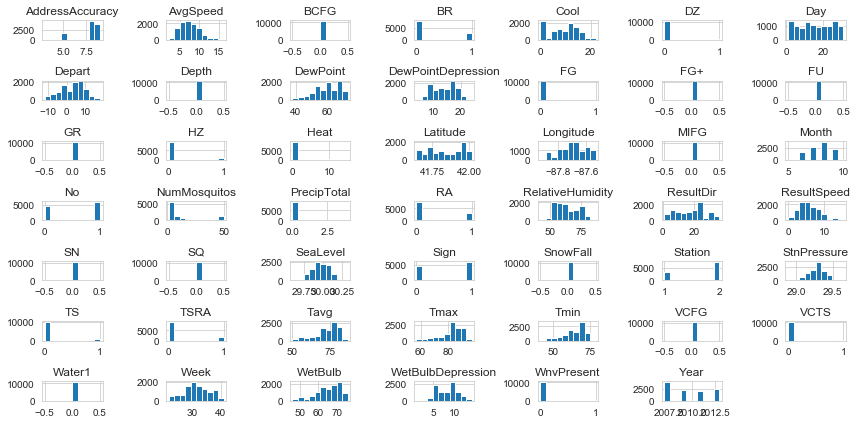

In [67]:
#This is the dataframe containing traing observation and the corresponding weather data.
df_train_weather.hist(figsize = (12, 6));
plt.tight_layout()

As per the distribution plots above, 
- Some features are aproximately distributed normally(AvgSpeed, Depart, Result Speed, SeaLevel, StnPressure)
- Some feature have zero values such as Depth, Heat, Snowfall, Water1.
    - Chicago is normally free of snow every year from May to September, so snowfall has zero data. 
    - So is  depth of snow during this time period and water1.
- Temperate is positively skewed for maximum temperature, Average temperature, Minimum temperature
    - Over the course of the year, the temperature typically varies from 22°F to 77degree F and there is positive skew for temperature. 
    - Daily high temperatures increase by 9°F, from 62°F to 71°F, rarely falling below 50°F or exceeding 83°F.
    - Daily low temperatures increase by 10°F, from 49°F to 58°F, rarely falling below 41°F or exceeding 68°F.
- Regarding categorical data 
     - Station2 has more observations as compared to Station1
     - WnvPresent has very few positive cases of Wnv present as compared to negative cases. As this is target variable, this imbalance needs to be addressed before modelling.

## Lineplot (TimeSeries)

In this section, we will look at the time series weather data to study the trend.

In [68]:
# Function to plot WnvPresent Against datetime of weather columns
def wnv_plots(df1,df2,df3,df4,title):
    plt.figure(figsize=(16,18))
    plt.subplot(211)
    plt.title("Number of Positive Observations", fontsize=10)
    df_train_weather_gb.groupby(['Year', 'Month'])['WnvPresent'].sum().plot.bar(color = 'r',width = 0.4, align = 'edge')
    plt.subplot(212)
    plt.title(title, fontsize=10)
    df1.plot(label = '2007')
    df2.plot(label = '2009')
    df3.plot(label = '2011')
    df4.plot(label = '2013')
    plt.legend()

In [69]:
# Groupby year, month and day to find the total number of Mosquitos caught on that day and the number of observations of WnvPresent
df_train_weather_gb = df_train_weather.groupby(['Year','Month','Day'])[['WnvPresent', 'NumMosquitos']].sum()
df_train_weather_gb

WnvPresent  NumMosquitos
Year Month Day                          
2007 5     29            0            40
     6     5             0           127
           26            0           216
           29            0            85
     7     2             0           240
           11            0          1103
           18            1           853
           19            0           687
           25            5          4069
           27            0           247
     8     1            18          6904
           2             3          2898
           3             0           204
           7            12          1780
           8             7          4186
           9             1           507
           15           37          4661
           16           16          4555
           17            7          1915
           21           32          1667
           22           33          4512
           24           25          1478
           28            9          4748
     9     4             8           524
           5            10          2021
           6             2          1511
           12            5          1193
           18            0           392
           19            1          1756
           24            2          1570
           25            0           333
     10    4             2          1373
           9             0           333
2009 5     28            0           190
     6     2             0           663
           3             0           348
           5             0           257
           12            0          1204
           15            0           345
           19            0           701
           22            0          2171
           26            0           798
           29            0           903
     7     6             0           719
           10            0           996
           13            0          1369
           17            0          1893
           24            2          1215
           27            2          1482
           31            1          1159
     8     7             0           878
           13            2           602
           25            7           691
           27            0           175
     9     3             1           129
           14            3           563
           17            0           743
           25            1           702
     10    1             0           212
2011 6     10            0           429
           17            0           830
           24            0           846
           30            0          1944
     7     11            0          2091
           15            0          2497
           25            3          2449
           29            8          1408
     8     5             5          1065
           12           11           824
           19            4           589
           26            4           490
     9     1             4           319
           2             3           551
           12            6           734
           16            3           821
           23            6           728
           30            0           184
2013 6     7             0           360
           14            0          1670
           21            0          1319
           27            0           439
           28            1           923
     7     8             0          1833
           12            7          4796
           19           15          4168
           25            2          1974
     8     1            22          2865
           8            34          3188
           15           20          1946
           22           30          2063
           29           38          2645
     9     6            32          2510
           12           23          2210
           19           11          1030
           26            4           505

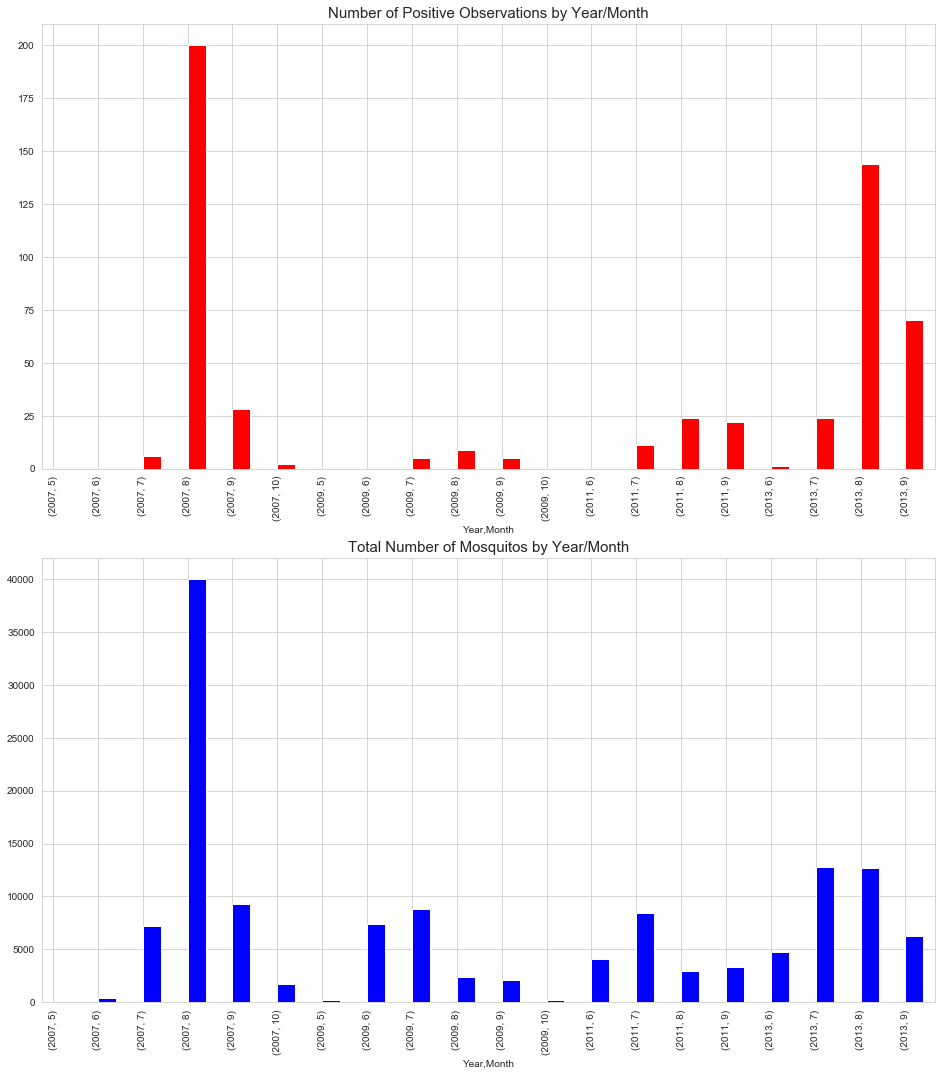

In [70]:
# Plot Barplot for WnvPresent and NumMosquitos
plt.figure(figsize=(16,18))
plt.subplot(211)
plt.title("Number of Positive Observations by Year/Month", fontsize=15)
df_train_weather_gb.groupby(['Year','Month'])['WnvPresent'].sum().plot.bar(color = 'r',width = 0.4, align = 'edge')
plt.subplot(212)
plt.title("Total Number of Mosquitos by Year/Month", fontsize=15)
df_train_weather_gb.groupby(['Year','Month'])['NumMosquitos'].sum().plot.bar(color = 'b',width = 0.4, align = 'edge')

From the BarPlot Above, the red bars represent WnvPresent and the blue bars represent Numbers of mosquitos caught in the traps.
Each Bar represent the total sum of WnvPresent/Mosquitos for the month of each respective year.

From the plot, we can see that there is a relationship between number of mosquitos and WnvPresent. However, there seems to be a lag between appearance of mosquitoes and the discovery of the WestNile Virus.

In year 2007, Mosquitoes started getting caught in large numbers in July. Meanwhile, the WestNile Virus only just getting started at that period as there is only a few counts before peaking in August. As the number of mosquitoes decrease, the number of WestNile Virus discovery decreases as well.

This can be seen in the following years as well. Mosquitoes will start appearing 1 month earlier, usually around June, before WestNile Virus get discovered in July.

In [71]:
df_temp = df_weather.set_index('Date')

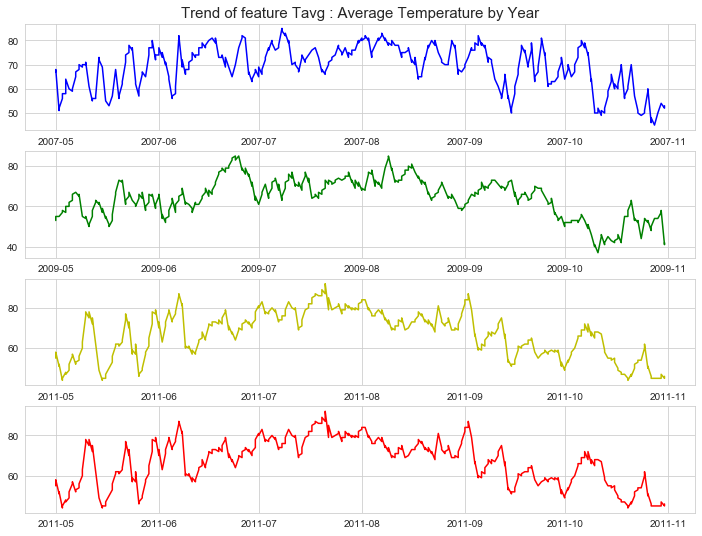

In [72]:
fig, axes = plt.subplots(nrows=4, figsize=(12,9))
axes[0].set_title("Trend of feature Tavg : Average Temperature by Year", fontsize=15)
axes[0].plot(df_temp['2007-05' : '2007-12']['Tavg'],c='b') # first plot
axes[1].plot(df_temp['2009-05' : '2009-12']['Tavg'],c='g') # second plot
axes[2].plot(df_temp['2011-05' : '2011-12']['Tavg'],c='y') # third plot
axes[3].plot(df_temp['2011-05' : '2011-12']['Tavg'],c='r') # third plot

The Lineplot above represents the average temperature per month from May to October.
 - The temperature in Chicago start rising around June and Peaks in the month of July. 
 - The Temperature starts dropping after August. 
 This variation in temperature is due to seasonal change summer followed by Wet month of August.

- There is a relationship between Temperature and observations of WestNile Virus. 
    - Drawing inference from Tavg trends and the barplot above titled - "Number of Positive Observations by Year/Month" 
         - WestNile Virus is first discovered in July, with average temperature at peak of the year
         - Highest observations of virus are discovered in August. 
         - Number of observations of WestNile Virus drops as temperature starts to drop over the months after Aug
- This Trend follows the theory that the WestNile Virus thrives in higher Temperatures.

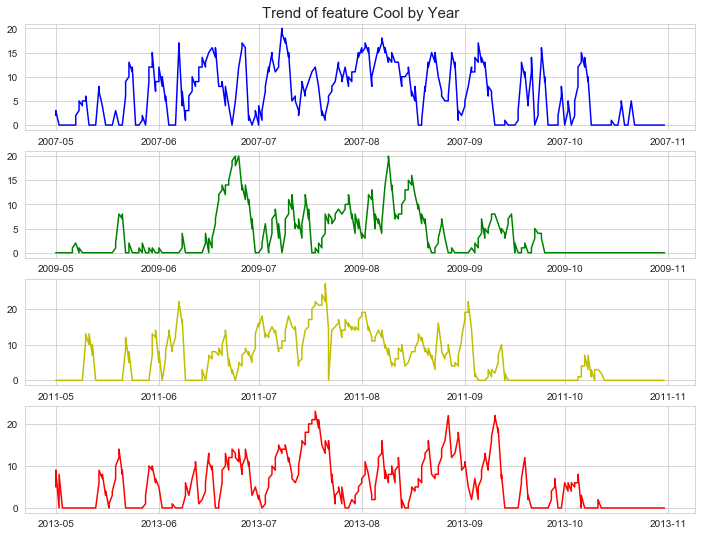

In [73]:
fig, axes = plt.subplots(nrows=4, figsize=(12,9))
axes[0].set_title("Trend of feature Cool by Year", fontsize=15)
axes[0].plot(df_temp['2007-05' : '2007-12']['Cool'],c='b') # first plot
axes[1].plot(df_temp['2009-05' : '2009-12']['Cool'],c='g') # second plot
axes[2].plot(df_temp['2011-05' : '2011-12']['Cool'],c='y') # third plot
axes[3].plot(df_temp['2013-05' : '2013-12']['Cool'],c='r') # third plot

- Drawing inference from Cold trends and the barplot above titled - "Number of Positive Observations by Year/Month" 
     - The trend is simlar to Tavg 
     - The feature Cold is related to Temperature and have the similar effect on the number of observations of WestNile Virus.

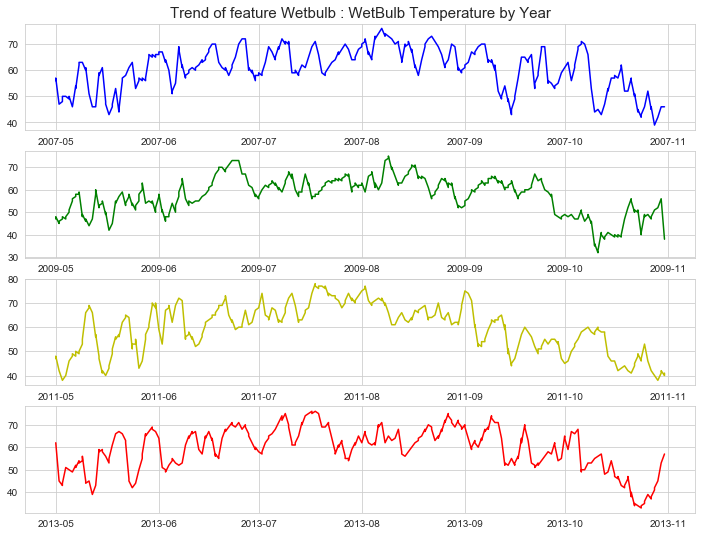

In [74]:
fig, axes = plt.subplots(nrows=4, figsize=(12,9))
axes[0].set_title("Trend of feature Wetbulb : WetBulb Temperature by Year", fontsize=15)
axes[0].plot(df_temp['2007-05' : '2007-12']['WetBulb'],c='b') # first plot
axes[1].plot(df_temp['2009-05' : '2009-12']['WetBulb'],c='g') # second plot
axes[2].plot(df_temp['2011-05' : '2011-12']['WetBulb'],c='y') # third plot
axes[3].plot(df_temp['2013-05' : '2013-12']['WetBulb'],c='r') # third plot

- The Lineplot above represents the average WetBulb Temperature per month from May to October. 
    - The wet-bulb temperature (WBT) is the temperature read by a thermometer covered in water-soaked cloth (wet-bulb thermometer) over which air is passed.
    - The wet-bulb temperature is the lowest temperature that can be reached under current ambient conditions by the evaporation of water only

- The line graph indicates a trend 
    - The WetBulb temperature in Chicago start rising around June and Peaks in the month of July. 
    - The WetBulb Temperature starts dropping after August. 

- Drawing inference from WetBulb Temperature trends and the barplot above titled - "Number of Positive Observations by Year/Month" 
     - The trend is simlar to Tavg and have the similar effect on the number of observations of WestNile Virus.
     - WestNile Virus is first discovered in July, when the average WetBulb temperature is at peak of the year
     - Highest observations of virus are discovered in August. 
     - Number of observations of WestNile Virus drops as WetBulb temperature starts to drop over the months after Aug
- This Trend follows the theory that the WestNile Virus thrives in higher Temperatures because the Wetbulb temperature, which is considered the lowest that can be reached, is still quite high around month of August

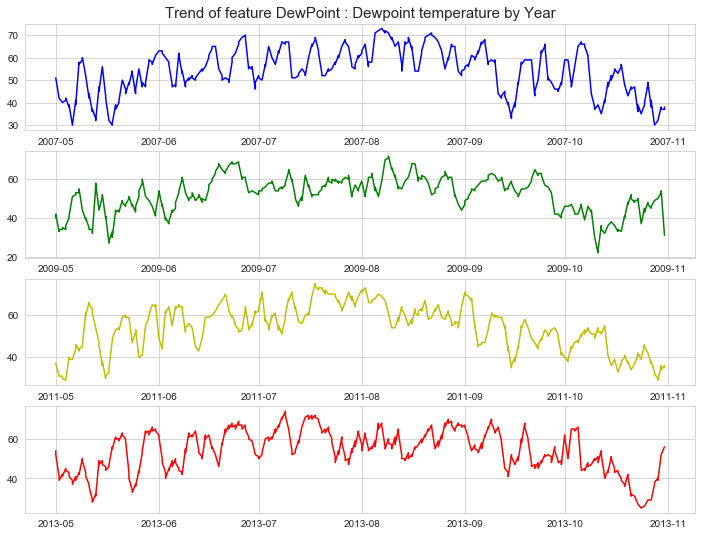

In [75]:
fig, axes = plt.subplots(nrows=4, figsize=(12,9))
axes[0].set_title("Trend of feature DewPoint : Dewpoint temperature by Year", fontsize=15)
axes[0].plot(df_temp['2007-05' : '2007-12']['DewPoint'],c='b') # first plot
axes[1].plot(df_temp['2009-05' : '2009-12']['DewPoint'],c='g') # second plot
axes[2].plot(df_temp['2011-05' : '2011-12']['DewPoint'],c='y') # third plot
axes[3].plot(df_temp['2013-05' : '2013-12']['DewPoint'],c='r'); # third plot

- The Lineplot above represents the DewPoint per month from May to October. 
    - DewPoint is the temperature where condensation of water droplets is possible. This has a relationship with humidity.
- The line graph indicates a trend 
    - The Dewpoint temperature in Chicago rise around June and Peaks in the month of July. 
    - The Dewpoint Temperature starts dropping after August.

- Drawing inference from Dewpoint trends and the barplot above titled - "Number of Positive Observations by Year/Month" 
     - The higher the temperature required for condensation, the drier the atmosphere will be which implies suitable for WestNile Virus
     The trend is simlar to Tavg and have the similar effect on the number of observations of WestNile Virus.
     - WestNile Virus is first discovered in July, when the Dewpoint temperature reaches the peak of the year
     - Highest observations of virus are discovered in August 
     - As the Dewpoint Temperature starts dropping after August Number of observations of WestNile Virus also drop
- This Trend follows the theory that the WestNile Virus thrives in higher Temperatures and drier conditions.

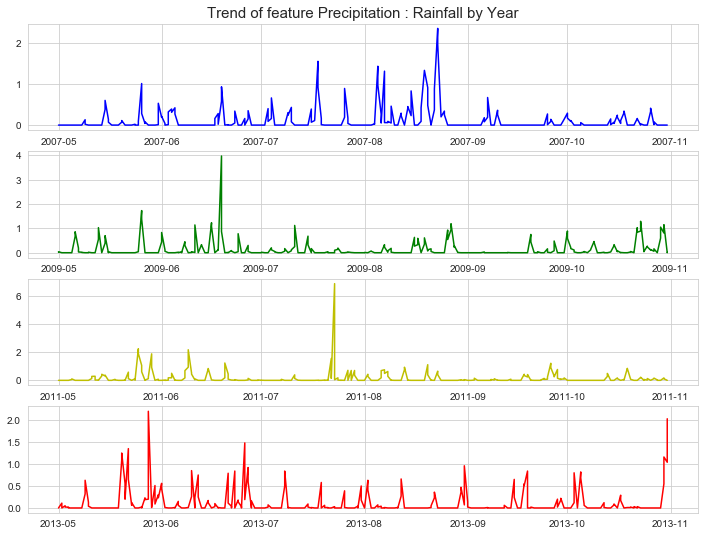

In [76]:
fig, axes = plt.subplots(nrows=4, figsize=(12,9))
axes[0].set_title("Trend of feature Precipitation : Rainfall by Year", fontsize=15)
axes[0].plot(df_temp['2007-05' : '2007-12']['PrecipTotal'],c='b') # first plot
axes[1].plot(df_temp['2009-05' : '2009-12']['PrecipTotal'],c='g') # second plot
axes[2].plot(df_temp['2011-05' : '2011-12']['PrecipTotal'],c='y') # third plot
axes[3].plot(df_temp['2013-05' : '2013-12']['PrecipTotal'],c='r') # third plot

Prepecipitation shows how much rain occured throughout the months. As you can see in year 2007 and 2013, there was alot of rain throughout the year compared to year 2009 and 2011. If you look at the bar chart above. During these 2 years, from July to August, there is a spike in number of mosquitoes caught in the traps and the number of postive obeservation of WnvPresent is also significantly higher, compared to the years with lesser rain occurance.

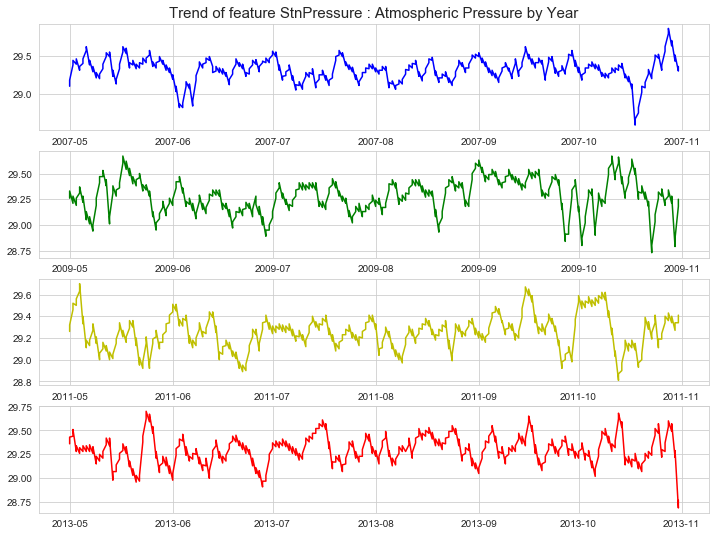

In [77]:
fig, axes = plt.subplots(nrows=4, figsize=(12,9))
axes[0].set_title("Trend of feature StnPressure : Atmospheric Pressure by Year", fontsize=15)
axes[0].plot(df_temp['2007-05' : '2007-12']['StnPressure'],c='b') # first plot
axes[1].plot(df_temp['2009-05' : '2009-12']['StnPressure'],c='g') # second plot
axes[2].plot(df_temp['2011-05' : '2011-12']['StnPressure'],c='y') # third plot
axes[3].plot(df_temp['2013-05' : '2013-12']['StnPressure'],c='r') # third plot

No trend and relationship between StnPressure over time with the number observations of WnvPresent.
This feature can be ignored during modelling.

## CountPlot

In this section, we will take a closer look at the number of training observations with respect to the species found,
trap, weather location and weather readings (point in time).

In [78]:
def draw_countplot(df, x, title, 
                   xlabel = None, ylabel = 'Number of Observations', 
                   hue = 'WnvPresent', loc = 'upper right', annot = True):
    fig, ax = plt.subplots(figsize=(18, 8))
    sns.set_style("white")
    sns.countplot(x = x, hue = hue, data = df, dodge = True, palette = ['blue', 'red'])
    ax.set_title(title, fontsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 20)
    legend = plt.legend(loc = loc)
    legend.get_texts()[0].set_text('West Nile Virus Not Detected')
    legend.get_texts()[1].set_text('West Nile Virus Detected')
    
    if annot == True:
        for p in ax.patches:
            ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                        ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 10)

In [79]:
def draw_barplot (df, groupby, 
                  target, title, 
                  xlabel = None,  ylabel = 'Number of Observations', 
                  rotation = 0):
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.grid(False)
    df.groupby([groupby])[target].sum().plot.bar(color = 'r')
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation)
    ax.set_ylabel(ylabel, fontsize = 20)
    for p in ax.patches:
        ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 10)


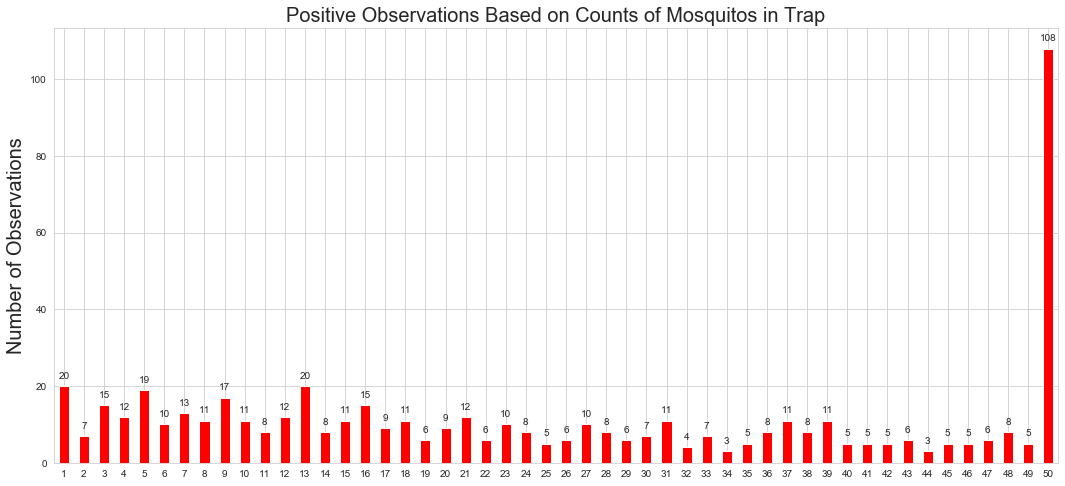

In [80]:
draw_barplot(df_train_weather, 
             'NumMosquitos', 
             'WnvPresent', 
             'Positive Observations Based on Counts of Mosquitos in Trap')

The above shows the presence of West Nile Virus based on the number of mosquitos caught by trap. For all traps with 1 mosquito caught, the total count of positive observation is 20. For all traps with 50 mosquitos caught, the total count of positive observation is 108.

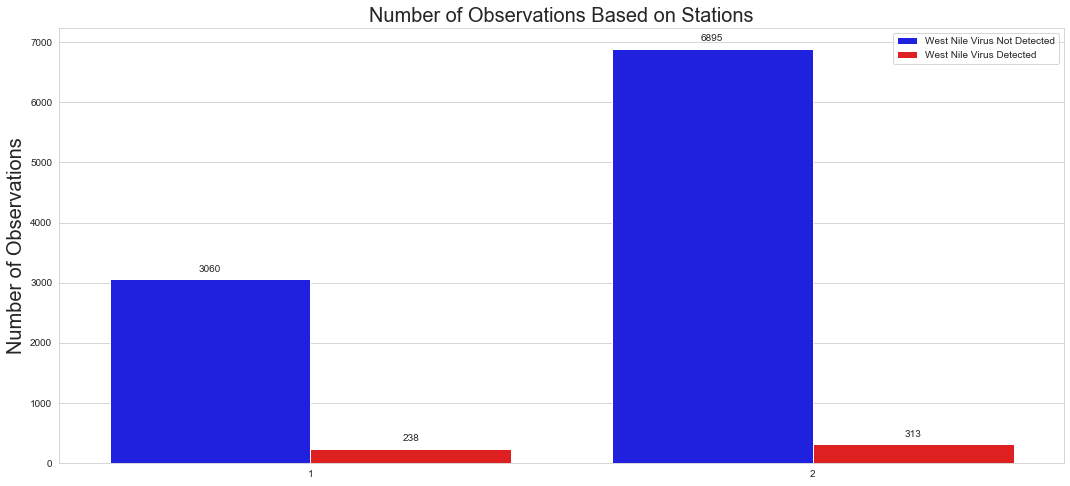

In [81]:
draw_countplot(df_train_weather, 
               'Station', 
               'Number of Observations Based on Stations')

From the above, we can see that station 2 has 313 positive observations while station 1 has 238 observations.

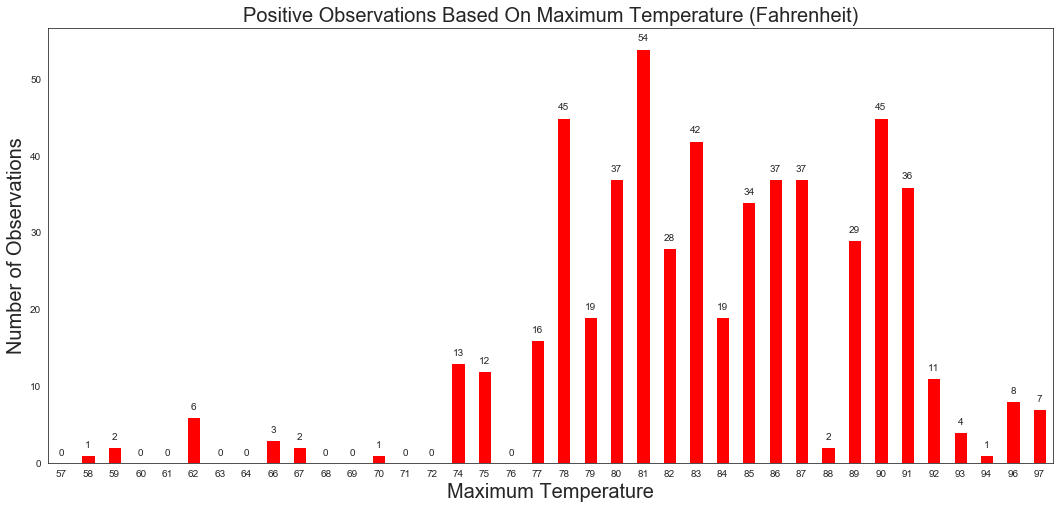

In [82]:
draw_barplot(df_train_weather, 
             'Tmax', 
             'WnvPresent', 
             'Positive Observations Based On Maximum Temperature (Fahrenheit)', 
             xlabel = 'Maximum Temperature',)

A bar plot only showing the number of positve observations based on maximum temperature, number of positive observations are comparatively higher when maximum temperature ranges betweeen 78F to 91F

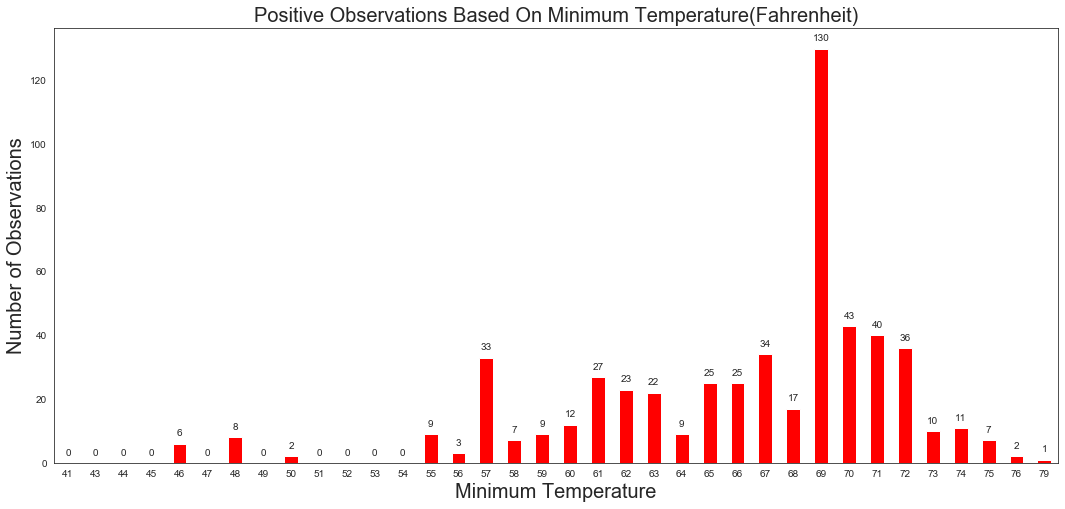

In [83]:
draw_barplot(df_train_weather, 
             'Tmin', 
             'WnvPresent', 
             'Positive Observations Based On Minimum Temperature(Fahrenheit)', 
             xlabel = 'Minimum Temperature')

Similar to maximum temperature, its apparent the number of positive observation increases in a certain range of minimum temperature between 67F and 72F

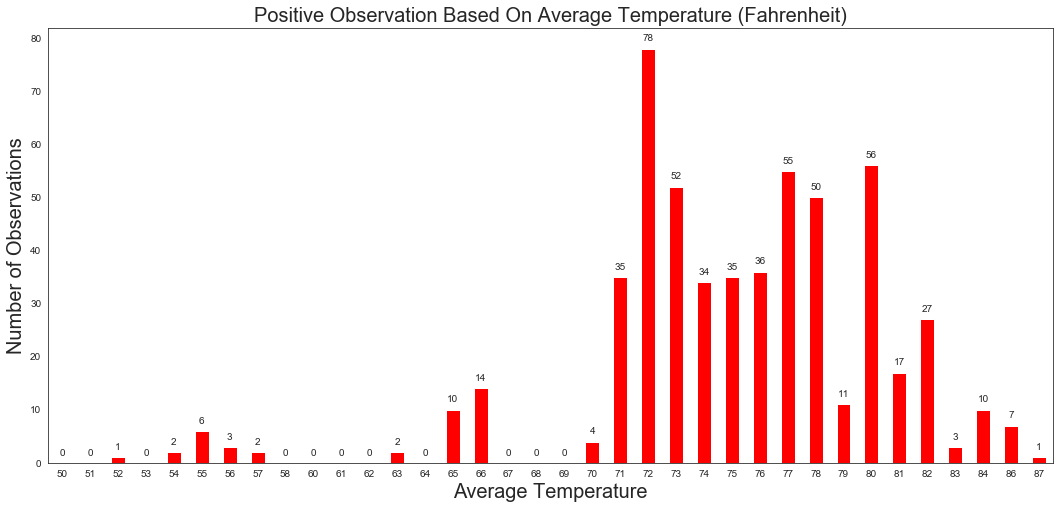

In [84]:
draw_barplot(df_train_weather, 
             'Tavg', 
             'WnvPresent', 
             'Positive Observation Based On Average Temperature (Fahrenheit)', 
             xlabel = 'Average Temperature')

We can observe that the number of positive observations peaks when the average temperature is between 71F and 81F

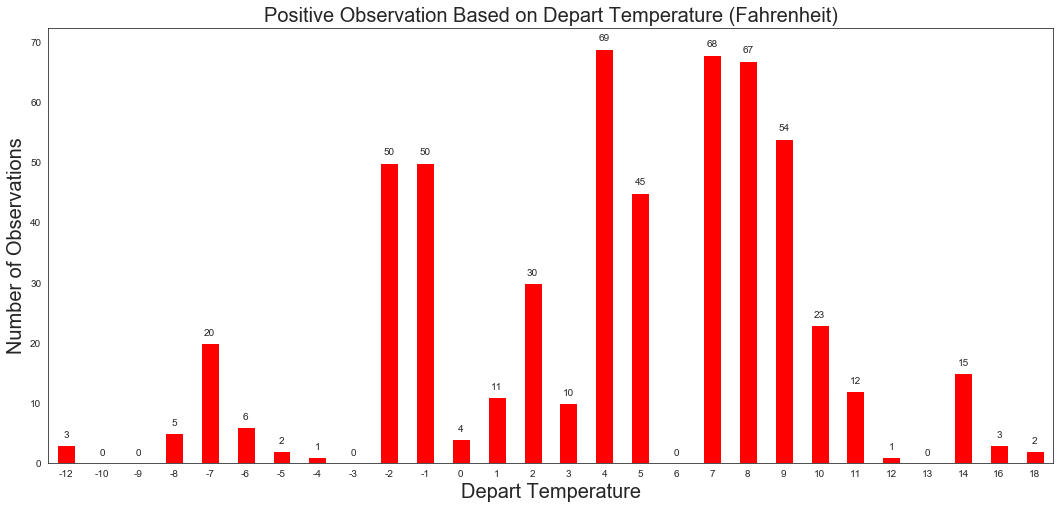

In [85]:
draw_barplot(df_train_weather, 
             'Depart', 
             'WnvPresent', 
             'Positive Observation Based on Depart Temperature (Fahrenheit)', 
             xlabel = 'Depart Temperature')

From [NOAA](#https://w2.weather.gov/climate/f6.php), depart is difference between the average temperature and the 30 year normal temperature for the date. 

There is an significant increase in positive West Nile Virus when the there is a difference between -2 and 9 fahrenheit for the date when compared to the normal 30 year temperature. 

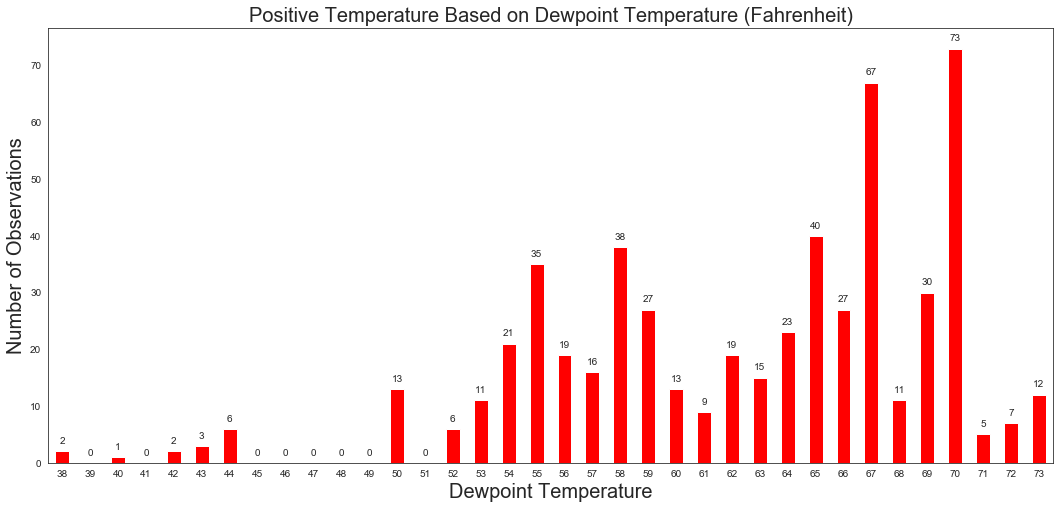

In [86]:
draw_barplot(df_train_weather, 
             'DewPoint', 
             'WnvPresent', 
             'Positive Temperature Based on Dewpoint Temperature (Fahrenheit)', 
             xlabel = 'Dewpoint Temperature')

The dew point is the temperature at which air is saturated with water vapor, which is the gaseous state of water. Below the dew point, liquid water will begin to condense on solid surfaces. Most people are comfortable with a dew-point temperature of 60 degrees Fahrenheit (16 degrees Celsius) or lower. At a higher dew point of, for example, 70 F (21 C), most people feel hot or "sticky" because the amount of water vapor in the air slows the evaporation of perspiration and keeps the body from cooling.

From the above, we can see that the number of mosquitos caught and tested positive for West Nile Virus increases when the dew point is between 54F to 71F.

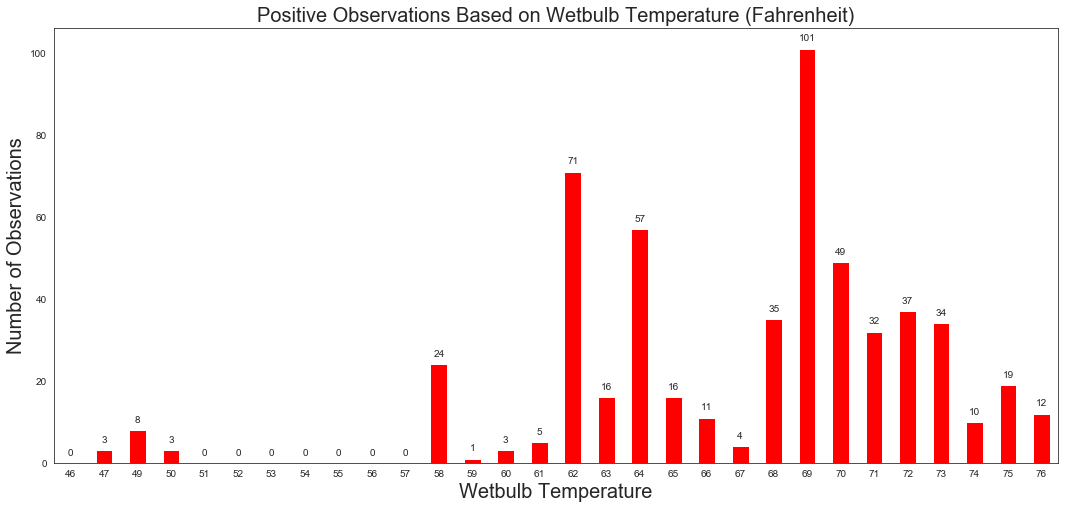

In [87]:
draw_barplot(df_train_weather, 
             'WetBulb', 
             'WnvPresent', 
             'Positive Observations Based on Wetbulb Temperature (Fahrenheit)', 
             xlabel = 'Wetbulb Temperature')

Wet bulb temperature tells you the lowest temperature that can be reached by evaporating water into the air. People feel more comfortable when wet-bulb temperature is low. At 100% relative humidity, the wet-bulb temperature is equal to the air temperature (dry-bulb temperature) and it is lower at lower humidity. Consider a thermometer wrapped in a water-moistened cloth. The drier, less humid the air, the faster the water will evaporate. The faster water evaporates, the lower the thermometer's temperature will be relative to air temperature. But water can only evaporate if the air around it can absorb more water. This is measured by comparing how much water is in the air, compared to the maximum which could be in the air—the relative humidity. 0% means the air is completely dry, and 100% means the air contains all the water it can hold in the present circumstances and it cannot absorb any more water (from any source).

In short, lower wetbulb temperature means lower humidity and lower mosquito

From the above, we can see that the number of positive West Nile Virus increases when the wet bulb temperature ranges between 62F to 73F

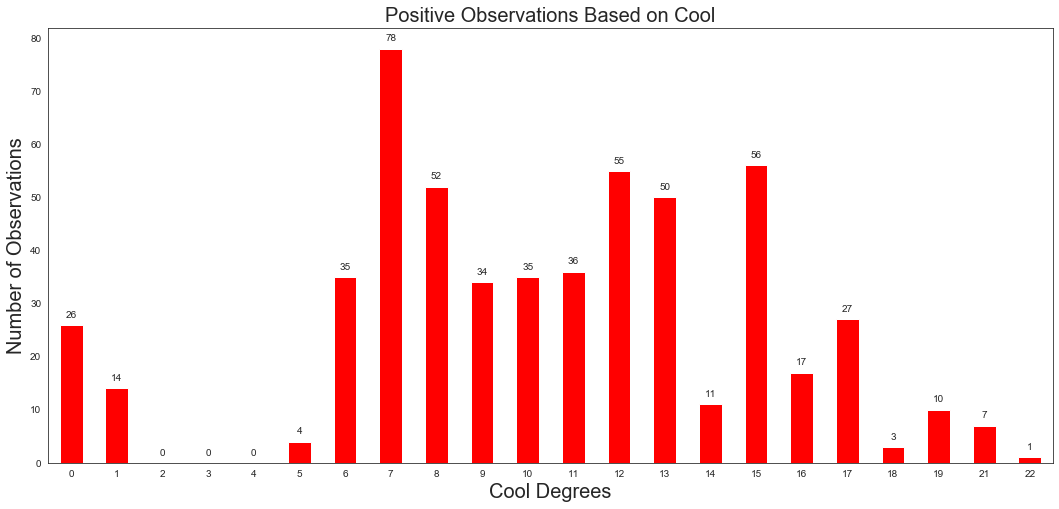

In [88]:
draw_barplot(df_train_weather, 
             'Cool', 
             'WnvPresent', 
             'Positive Observations Based on Cool', 
             xlabel = 'Cool Degrees')

Heating or Cooling = Average Temperature - 65 degrees (If positive, it is a cooling degree day, if negative, it is a heating degree day. Heating means temperature is low and  building need heating mechanism to keep temperature cool. Cooling means temperature is high and building will use cooling mechanism. The magnitude of the difference is the number of days. 

For example, if your average temperature in September in 50 degrees, the difference of the average temperature for month and the reference temperature of 65 degrees would yield a minus 15 indicating 15 Heating Degree Days

Increase in positive observations when the day's average temperature is 6F to 15F above 65F (71F to 80F). Which reconfirms that virus thrives in comparitively hotter temperature conditions.

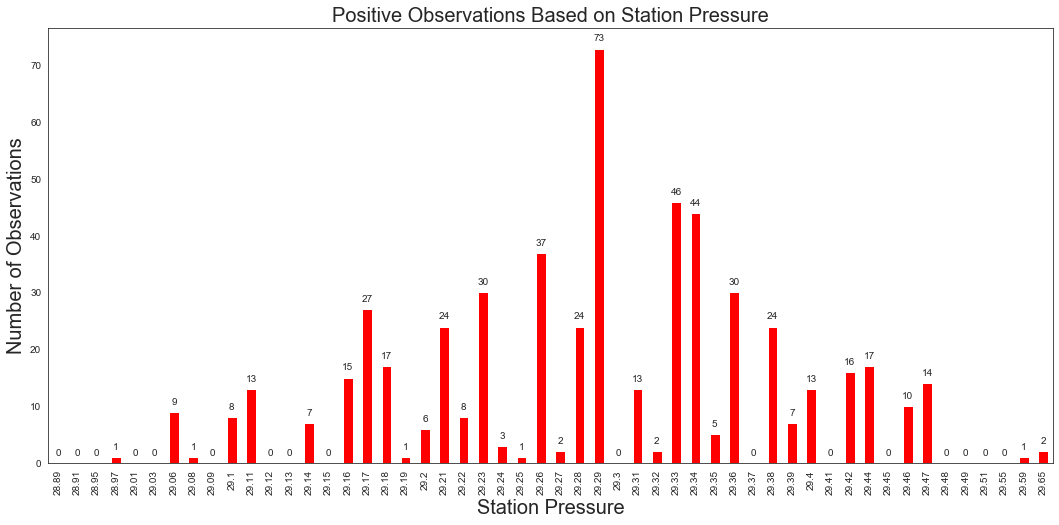

In [89]:
draw_barplot(df_train_weather, 
             'StnPressure', 
             'WnvPresent', 
             'Positive Observations Based on Station Pressure', 
             rotation = 90, 
             xlabel = 'Station Pressure')

There is an increase in positive observations when the station pressure is between 29.16 to 29.44

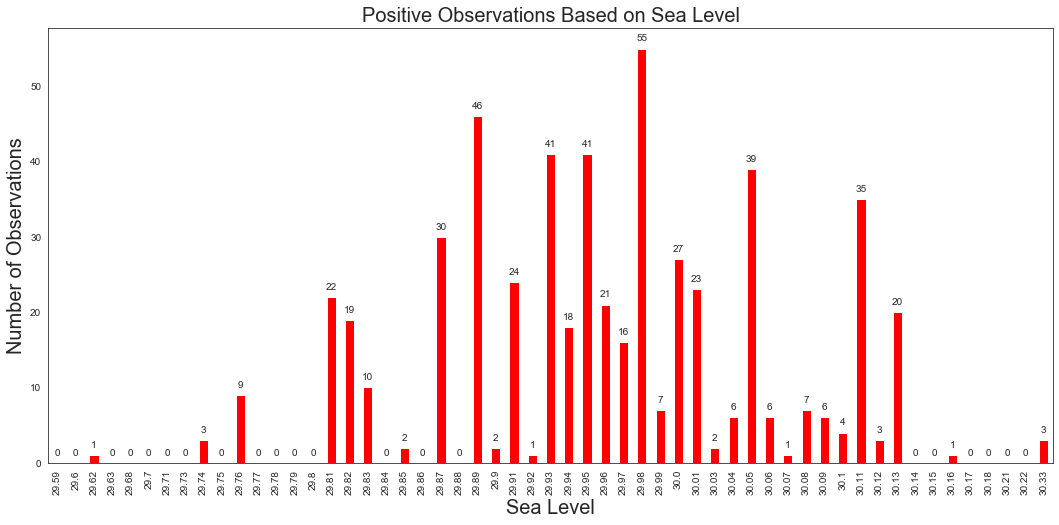

In [90]:
draw_barplot(df_train_weather, 
             'SeaLevel', 
             'WnvPresent', 
             'Positive Observations Based on Sea Level', 
             rotation = 90, 
             xlabel = 'Sea Level')

Number of positive observations increases when sea level is between 29.81 and 30.13

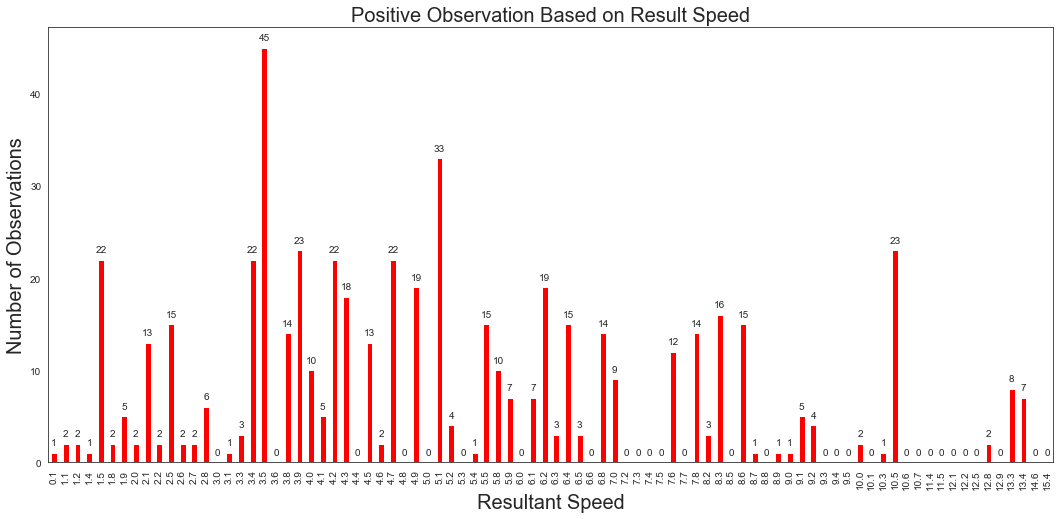

In [91]:
draw_barplot(df_train_weather, 
             'ResultSpeed', 
             'WnvPresent', 
             'Positive Observation Based on Result Speed', 
             rotation = 90, 
             xlabel = 'Resultant Speed')

No distinct pattern was observed in relation to the number of positive observations and resultant speed.

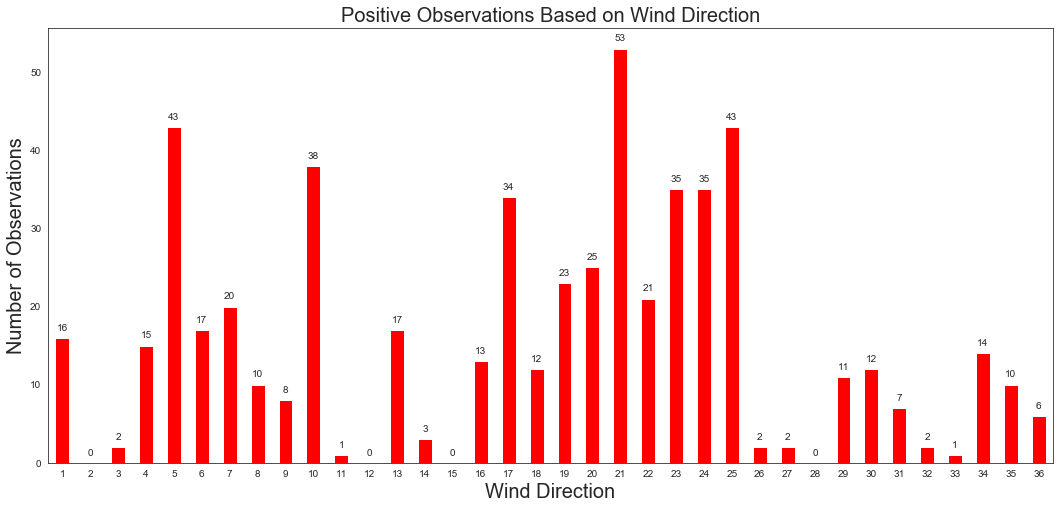

In [92]:
draw_barplot(df_train_weather, 
             'ResultDir', 
             'WnvPresent', 
             'Positive Observations Based on Wind Direction',
             xlabel = 'Wind Direction')

Its not obvious, May be there could be a correlation between the direction of the wind and location of positive observations. Mosquitos may fly in the direction of the wind

## Heatmap / Trap Locations

In this section, we will take a look at the heatmap of the train and weather variables to understand their correlations and to view the geographical locations of the trap and the extent of the virus outbreak for year 2007,2009,2011 and 2013.

In [93]:
# Checking the correlation of all independent variables with WnvPresent
df_train_weather.corr()['WnvPresent'].sort_values(ascending=False)

WnvPresent            1.000000
NumMosquitos          0.196820
Week                  0.104171
Month                 0.100143
DewPoint              0.084904
WetBulb               0.078905
Tmin                  0.065182
FG                    0.061425
BR                    0.060517
Tavg                  0.059881
RelativeHumidity      0.056935
Depart                0.055436
Cool                  0.052920
Year                  0.050865
Tmax                  0.047580
TSRA                  0.033807
Latitude              0.028697
HZ                    0.023776
RA                    0.022331
PrecipTotal           0.021312
TS                    0.017313
SeaLevel              0.009346
Day                   0.008245
AddressAccuracy       0.008064
ResultDir            -0.001229
StnPressure          -0.004591
DZ                   -0.010551
AvgSpeed             -0.031869
WetBulbDepression    -0.032766
VCTS                 -0.035231
ResultSpeed          -0.044529
Sign                 -0.050462
No      

(23.0, 0.0)

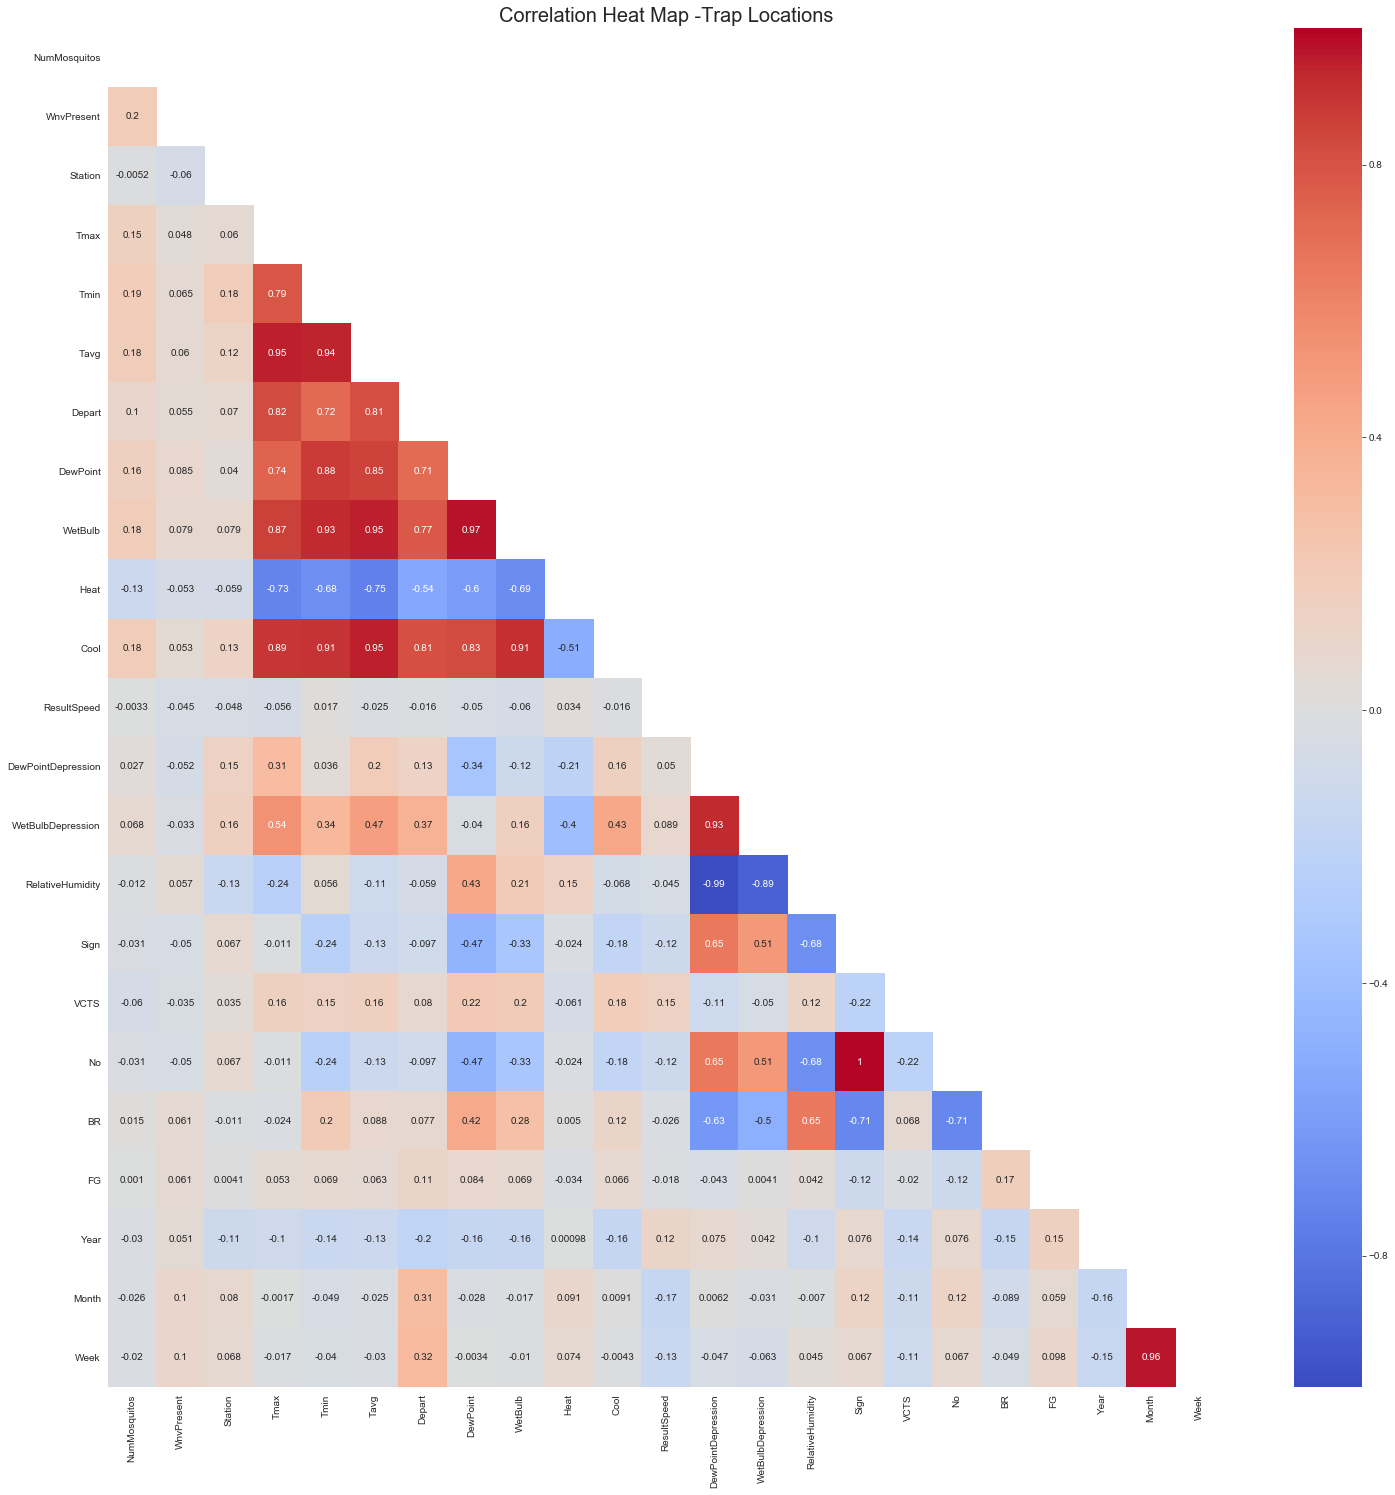

In [94]:
cols_to_exclude= ['Water1', 'Depth', 'SnowFall', 'Day', 'AddressAccuracy','Latitude','Longitude',\
                  'BCFG', 'GR', 'FG+', 'SN', 'VCFG', 'MIFG', 'SQ', 'FU','HZ', 'RA', 'TS', 'DZ',\
                  'PrecipTotal', 'SeaLevel','AvgSpeed', 'AvgSpeed', 'TSRA', 'StnPressure', 'ResultDir'
                 ]


#plt.figure(figsize = (15, 15))
fig, ax = plt.subplots(figsize=(25,25))


mask = np.zeros_like(df_train_weather[[x for x in df_train_weather.columns if x not in cols_to_exclude]].corr(),
                     dtype=np.bool) #['Water1', 'Depth', 'SnowFall']]].corr(), 
mask[np.triu_indices_from(mask)] = True
plt.title('Correlation Heat Map -Trap Locations',fontsize=20)
sns.heatmap(df_train_weather[[x for x in df_train_weather.columns if x not in cols_to_exclude]].corr(),
            annot = True, mask = mask, cmap = 'coolwarm') #square = True, cmap = 'coolwarm_r', cbar = False)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

From the above heatmap, we can see that there are quite a number of features that is correlated with one another which need to be further explored.

Map outbreaks of West Nile Virus( WNV) 

In [95]:
traps1 = df_traps[df_traps.WnvPresent==1]
traps0 = df_traps[df_traps.WnvPresent==0]

traps1 = traps1[['Longitude', 'Latitude']].drop_duplicates().values
traps0 = traps0[['Longitude', 'Latitude']].drop_duplicates().values

In [96]:
traps0[:,0]

array([-87.800991, -87.769279, -87.824812, -87.666455, -87.654491,
       -87.654224, -87.655232, -87.694259, -87.632085, -87.676709,
       -87.64886 , -87.666014, -87.677512, -87.61156 , -87.795585,
       -87.687769, -87.760886, -87.649642, -87.812827, -87.832763,
       -87.811506, -87.698457, -87.750938, -87.689778, -87.763416,
       -87.701431, -87.64997 , -87.666901, -87.627561, -87.724608,
       -87.76007 , -87.776792, -87.629798, -87.702575, -87.700117,
       -87.667736, -87.675919, -87.800515, -87.716277, -87.752329,
       -87.707973, -87.614258, -87.730698, -87.69181 , -87.733974,
       -87.757639, -87.797127, -87.777921, -87.747113, -87.686763,
       -87.79518 , -87.719887, -87.694991, -87.696269, -87.656913,
       -87.648064, -87.696293, -87.675088, -87.674677, -87.785288,
       -87.787992, -87.66214 , -87.716788, -87.598865, -87.794896,
       -87.688267, -87.776385, -87.777189, -87.705085, -87.703736,
       -87.748367, -87.677737, -87.729384, -87.726737, -87.678

In [97]:
traps0[:,1]

array([41.95469 , 41.994991, 41.974089, 41.9216  , 41.891118, 41.867108,
       41.896282, 41.919343, 41.921965, 41.688324, 41.862292, 41.720848,
       41.731922, 41.891126, 41.999129, 42.01743 , 41.907645, 41.732984,
       41.981964, 41.944869, 42.011601, 41.94983 , 41.979243, 41.986921,
       41.801498, 41.906638, 41.723195, 41.868077, 41.869216, 41.662014,
       41.961743, 41.953067, 41.878114, 41.958271, 41.932094, 41.994469,
       42.006858, 41.916265, 41.846075, 41.918705, 41.682587, 41.725517,
       41.948167, 41.963976, 41.953705, 41.964242, 41.990284, 42.008314,
       41.991429, 41.843811, 41.921177, 41.852652, 41.857402, 41.868142,
       41.846283, 41.721474, 41.869107, 41.719059, 41.966987, 41.923738,
       41.970248, 42.010412, 41.89923 , 41.692555, 41.94016 , 41.903002,
       41.942114, 41.960616, 41.883284, 41.704336, 41.962728, 41.836644,
       41.837085, 41.911824, 41.823065, 41.801179, 41.800737, 41.778297,
       41.77166 , 41.759346, 41.768388, 41.797616, 

In [98]:
traps1[:,0]

array([-87.531635, -87.599862, -87.800991, -87.824812, -87.676709,
       -87.677512, -87.666901, -87.724608, -87.69181 , -87.777921,
       -87.794896, -87.752411, -87.627796, -87.642984, -87.585413,
       -87.536497, -87.535198, -87.795585, -87.832763, -87.811506,
       -87.614258, -87.787992, -87.688267, -87.565666, -87.546587,
       -87.666455, -87.654224, -87.655232, -87.812827, -87.701431,
       -87.776792, -87.629798, -87.752329, -87.707973, -87.757639,
       -87.797127, -87.747113, -87.677737, -87.679447, -87.703047,
       -87.666343, -87.736812, -87.778927, -87.538693, -87.64997 ,
       -87.800515, -87.598865, -87.729384, -87.726737, -87.797894,
       -87.666014, -87.649642, -87.559308, -87.582699, -87.604498,
       -87.716277, -87.776385, -87.703736, -87.60088 , -87.612922,
       -87.590773, -87.689778, -87.79518 , -87.726549, -87.64886 ,
       -87.648064, -87.745602, -87.71188 , -87.740029, -87.763416,
       -87.731435, -87.605294, -87.862995, -87.890615, -87.930

In [99]:
traps1[:,1]

array([41.686398, 41.673408, 41.95469 , 41.974089, 41.688324, 41.731922,
       41.868077, 41.662014, 41.963976, 42.008314, 41.94016 , 41.778297,
       41.821582, 41.803423, 41.726465, 41.702724, 41.680946, 41.999129,
       41.944869, 42.011601, 41.725517, 41.970248, 41.903002, 41.704572,
       41.740641, 41.9216  , 41.867108, 41.896282, 41.981964, 41.906638,
       41.953067, 41.878114, 41.918705, 41.682587, 41.964242, 41.990284,
       41.991429, 41.836644, 41.801179, 41.77166 , 41.822536, 41.798697,
       41.776156, 41.659112, 41.723195, 41.916265, 41.692555, 41.837085,
       41.911824, 41.797616, 41.720848, 41.732984, 41.678618, 41.729669,
       41.644612, 41.846075, 41.942114, 41.704336, 41.773215, 41.754676,
       41.754292, 41.986921, 41.921177, 41.82561 , 41.862292, 41.721474,
       41.759346, 41.800737, 41.772846, 41.801498, 41.743402, 41.750498,
       41.992478, 41.974689, 41.957799, 41.904194, 41.951866, 41.923738,
       41.973845, 41.984809, 41.948167, 41.98728 , 

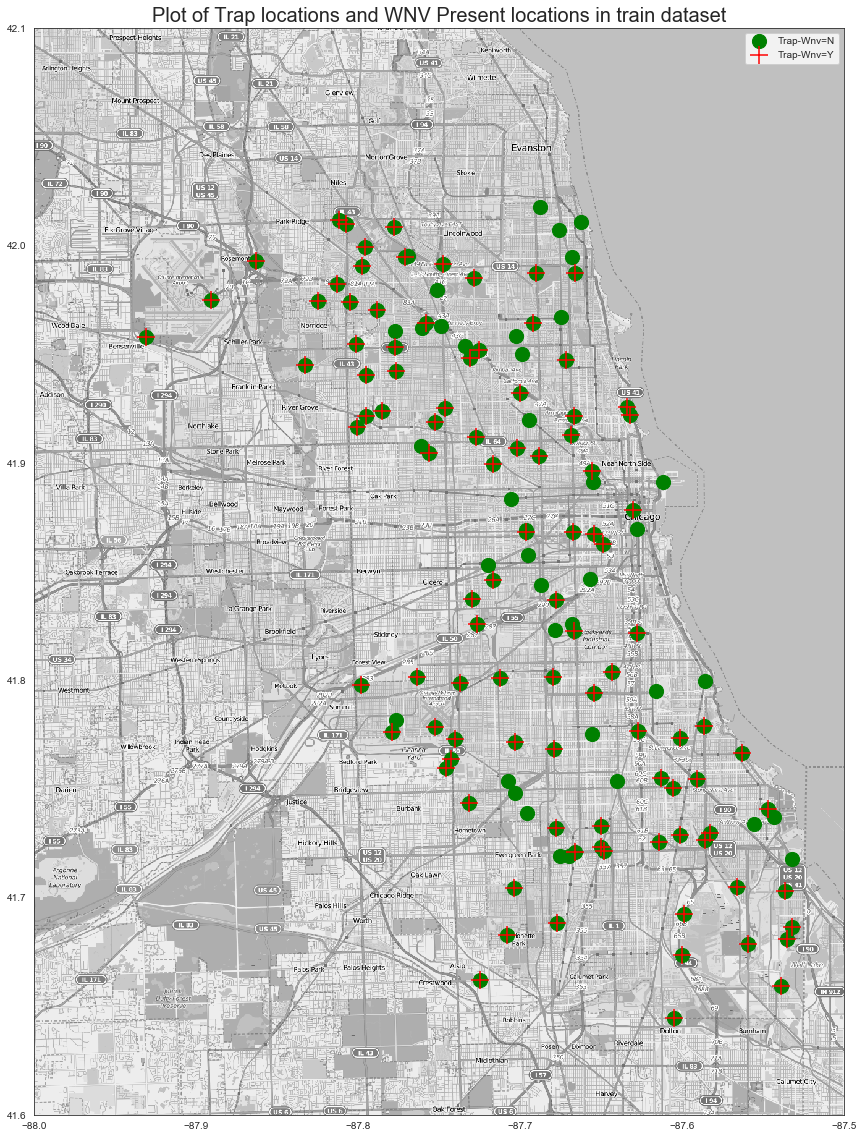

In [100]:
mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")
#traps = pd.read_csv('./train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(20,20))
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

traps1 = df_traps[df_traps.WnvPresent==1]
traps0 = df_traps[df_traps.WnvPresent==0]

traps1 = traps1[['Longitude', 'Latitude']].drop_duplicates().values
traps0 = traps0[['Longitude', 'Latitude']].drop_duplicates().values

# plt.scatter(traps0[:,0], traps0[:,1], color='pink', marker='*', alpha=1, label='Wnv = No')
# plt.scatter(traps1[:,0], traps1[:,1], color='purple', marker='*', alpha=1, label='Wnv = Yes')

# plt.scatter(traps0[:,0], traps0[:,1], alpha=1, zorder=1, c = 'lime', s=300, label = 'Trap-Wnv=N')
# plt.scatter(traps1[:,0], traps1[:,1], alpha=1, zorder=1, c = 'r', s=400, marker='+', label = 'Trap-Wnv=Y')
            
plt.scatter(traps0[:,0], traps0[:,1], alpha=1, zorder=1, color='green', s=200, label = 'Trap-Wnv=N')
plt.scatter(traps1[:,0], traps1[:,1], alpha=1, zorder=1, color='red', s=300, marker='+', label = 'Trap-Wnv=Y')

plt.gca().set_title('Plot of Trap locations and WNV Present locations in train dataset', size = 20)

plt.legend();

plt.savefig('trap_map.png');

Geographical location of Traps and the extent of outbreak(colour in RED) distributed over a year

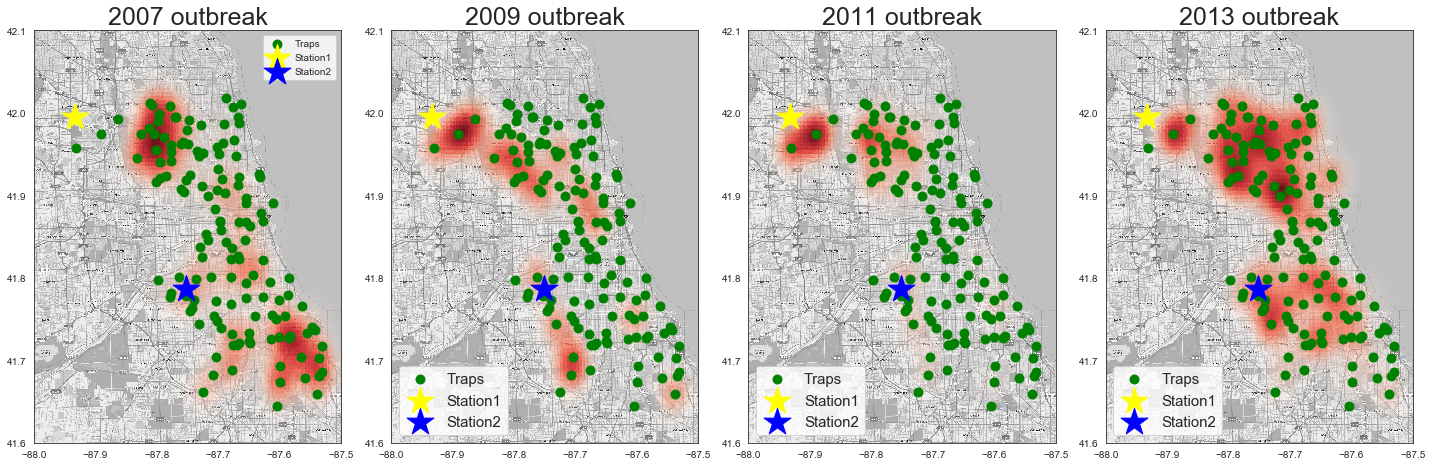

In [101]:
 
#plot the heatmap of outbreak, green = station1, yellow = station2
mapdata = np.loadtxt('../assets/mapdata_copyright_openstreetmap_contributors.txt')
# df_traps = pd.read_csv('../assets/clean/train_clean.csv', \
#                     parse_dates=['Date'])[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]
# df_traps   = pd.read_pickle('../assets/train_clean.pkl')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)
#plt.figure(figsize=(18,6))
plt.figure(figsize=(20,10))
for year, subplot in zip([2007, 2009, 2011, 2013], [141, 142, 143, 144]):
    sightings = df_traps[(df_traps['WnvPresent'] == 1) & (df_traps['Date'].apply(lambda x: x.year) == year)]
    sightings = sightings.groupby(['Date', 'Trap', 'Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
    X = sightings[['Longitude', 'Latitude']].values
    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)
    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.subplot(subplot)
    plt.gca().set_title(str(year)+' outbreak', size = 25)
    plt.imshow(mapdata,
              cmap=plt.get_cmap('gray'),
              extent=lon_lat_box,
              aspect=aspect)
    plt.imshow(zv,
              origin='lower',
              cmap=alpha_cm,
              extent=lon_lat_box,
              aspect=aspect
              )
    plt.tight_layout()
    locations = df_traps[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations[:,0], locations[:,1], label = 'Traps', s=80, color='green') # marker='x', 

   #plot the locations of 2 weather stations
    station1_lat  = 41.995
    station1_long = -87.933
    station2_lat  = 41.786
    station2_long = -87.752
    plt.scatter(station1_long,station1_lat, marker='*',color='yellow',s=800, label = 'Station1')
    plt.scatter(station2_long,station2_lat, marker='*',color='blue',s=800, label = 'Station2')
    plt.legend()#loc='upper right')#frameon=False, loc='upper right', bbox_to_anchor=(1, 1));
    
    params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
    plt.rcParams.update(params)
    plt.savefig('yearly_outbreak_map.png');

- Station 1 (Yellow), Station 2 (Blue).
    - There were 2 clear clusters of outbreak(in red) in 2007. 
    - In 2009 and 2011, the clusters near station 2 has disappeared and the outbreak near station 1 has scaled down.  
    - However in 2013, the situation has gotten worse with a larger clusters formed near station 1. 
- We will investigate further on these hotspots to find out the possible causes.

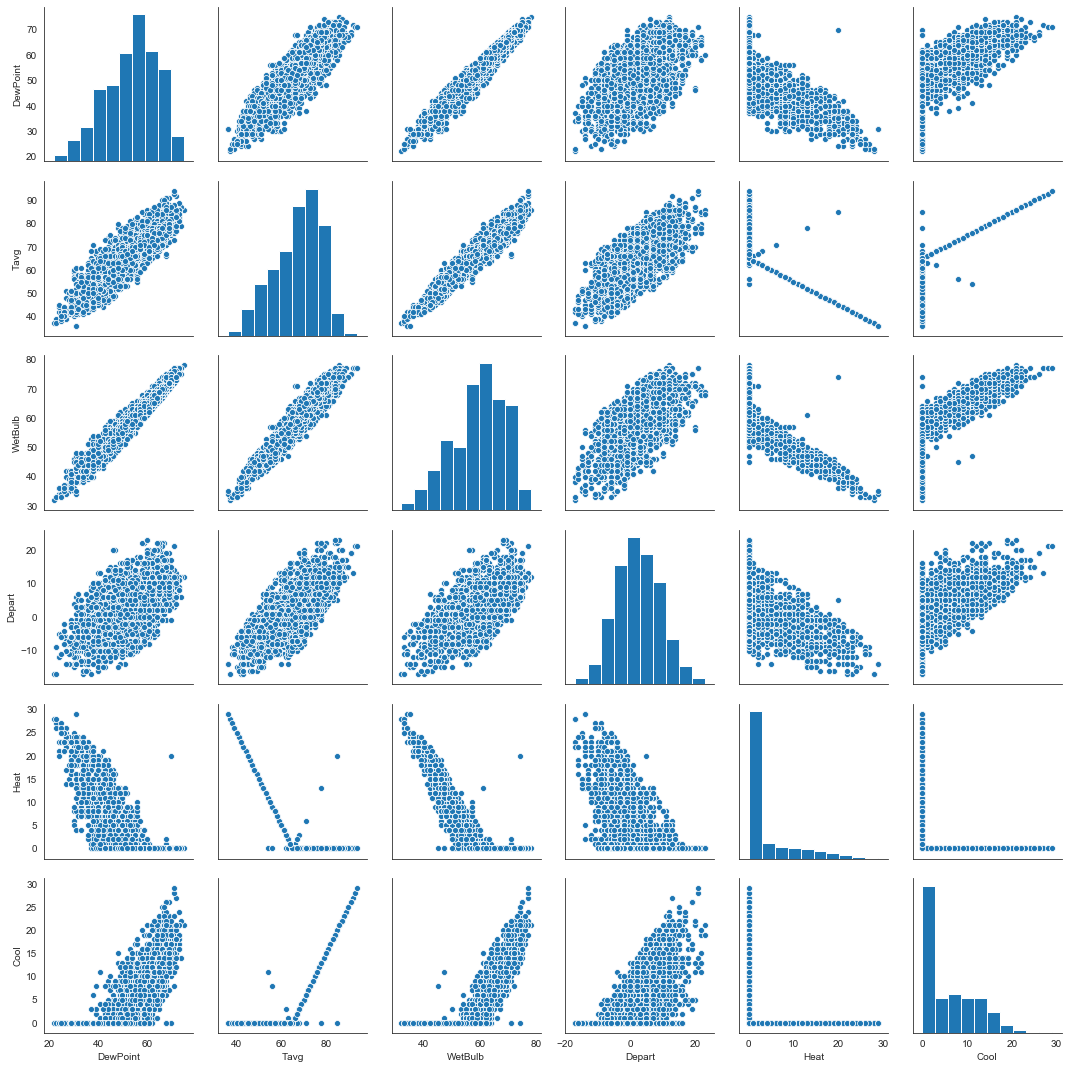

In [102]:
#pairplot on weather variables to see if there are clear correlation between them
sns.pairplot(df_weather[['DewPoint','Tavg','WetBulb','Depart','Heat','Cool']])

- From above plots we can infer that 
    - DewPoint and WetBulb are positively correlated as both are measurement of humidity of the air. 
    - The strong positive correlation between Tavg (Average temperature) and WetBulb indicates that the relative humidity is 100%. Hence wet bulb thermometer can no longer be cooled by evaporation, so it will read the same as an unwrapped thermometer(air temperature).

 Notes
 - Wet bulb temperature is the lowest temperature to which air can be cooled by the evaporation of water into the air at a constant pressure. The wet-bulb temperature (WBT) is the temperature read by a thermometer covered in water-soaked cloth (wet-bulb thermometer) over which air is passed. At 100% relative humidity, the wet-bulb temperature is equal to the air temperature (dry-bulb temperature) and it is lower at lower humidity.
 
- The dew point is the temperature to which air must be cooled to become saturated with water vapor. When further cooled, the airborne water vapor will condense to form liquid water (dew). A higher dew point means there is more moisture in the air.

In [103]:
#df_weather.columns

## Trap Analysis (Identify Hotspots)

In this section, we will study the number of positive observations obtained per Trap Weekly and Monthly so that we can find out where are the hotspots (Traps with high number of WnvPresent).

### Get No. of positive observations per week in each Trap

In [104]:
#for each trap, find how many times within a week that it has positive wnvpresent
df_trap_wk = df_train_weather.groupby(['Trap', 'Year', 'Month', 'Week'])[['WnvPresent']].sum()
df_trap_wk.reset_index(inplace=True)
df_trap_wk.sort_values(by=['Year', 'WnvPresent'],ascending=False).head(5)

Trap  Year  Month  Week  WnvPresent
3968  T900  2013      8    35          12
3964  T900  2013      8    31           9
3969  T900  2013      9    36           9
59    T002  2013      8    32           4
265   T009  2013      8    35           3

### Get No. of positive observations per month in each Trap

In [105]:
#aggregate weekly count to monthly count
df_trap_mth = df_train_weather.groupby(['Trap', 'Year', 'Month'])[['WnvPresent']].sum()
df_trap_mth.reset_index(inplace=True)
df_trap_mth.sort_values(by=['Year', 'WnvPresent'],ascending=False).head(5)

Trap  Year  Month  WnvPresent
1438  T900  2013      8          28
1439  T900  2013      9          15
22    T002  2013      8           7
241   T028  2013      8           5
258   T030  2013      8           5

We observed that trap T900 is the top hotspot in 2013 with the highest number of positive observations. Need to investigate this trap in greater details.

### Top Hotspots for Year 2013

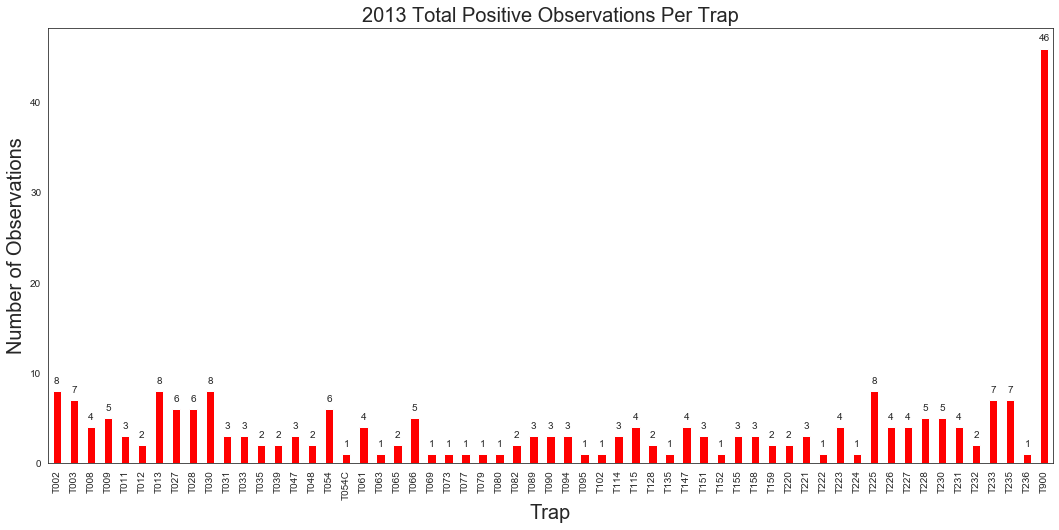

In [106]:
condition = (df_trap_wk['Year']==2013) & (df_trap_wk['WnvPresent']>0)
draw_barplot(df_trap_wk[condition], 
             'Trap', 
             'WnvPresent', 
             '2013 Total Positive Observations Per Trap', 
             rotation = 90, 
             xlabel = 'Trap')

### Top Hotspot for Year 2011

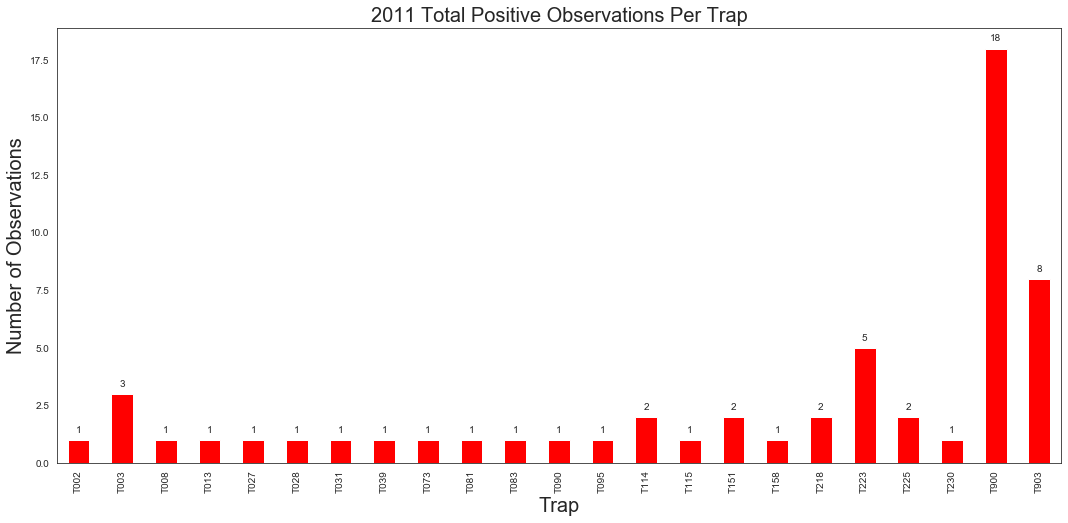

In [107]:
condition = (df_trap_wk['Year']==2011) & (df_trap_wk['WnvPresent']>0)
draw_barplot(df_trap_wk[condition], 
             'Trap',
             'WnvPresent', 
             '2011 Total Positive Observations Per Trap',
             rotation = 90, 
             xlabel = 'Trap')

### Top Hotspot for Year 2009

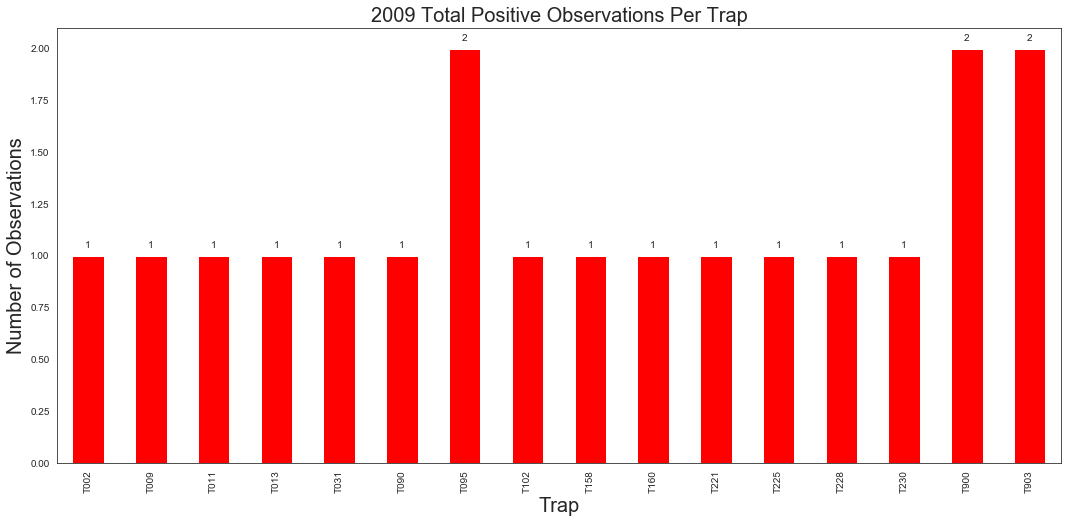

In [108]:
condition = (df_trap_wk['Year']==2009) & (df_trap_wk['WnvPresent']>0)
draw_barplot(df_trap_wk[condition], 
             'Trap', 
             'WnvPresent', 
             '2009 Total Positive Observations Per Trap', 
             rotation = 90, 
             xlabel = 'Trap')

### Top Hotspot for Year 2007

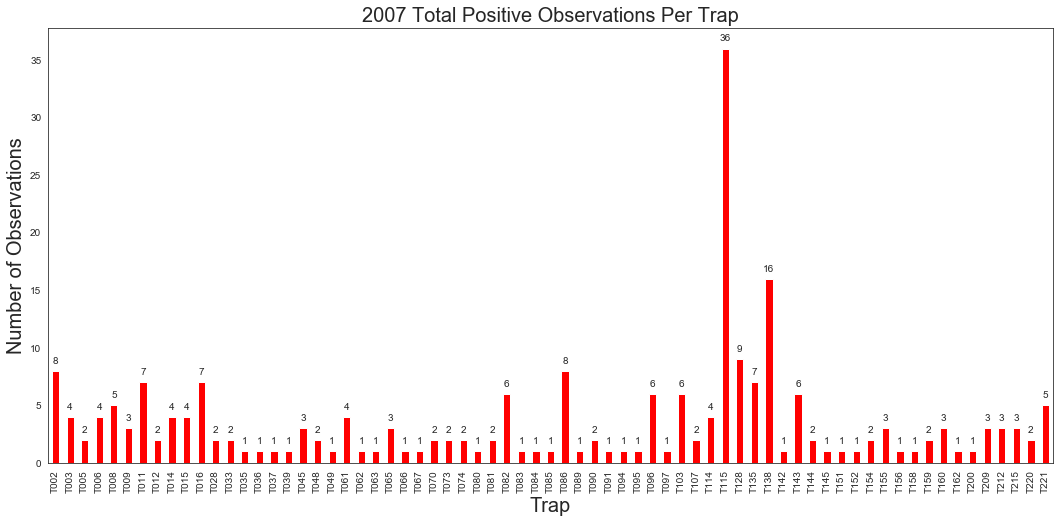

In [109]:
condition = (df_trap_wk['Year']==2007) & (df_trap_wk['WnvPresent']>0)
draw_barplot(df_trap_wk[condition], 
             'Trap', 
             'WnvPresent', 
             '2007 Total Positive Observations Per Trap', 
             rotation = 90, 
             xlabel = 'Trap')


- T900 is the top hotspot for years 2011 and 2013 with positive observations much higher than others. 
- In 2009 traps T900, T903 and T905 share the top slot for hotspot with 2 observatios(This year is least observations compared to other years.
- In 2007, T115 is the top hotspot with 35 observations

## Investigate Top Hotspot (Trap T900 on weather variables)

In this section, we are investigating weather variables that may contribute to the breeding of mosquitos at Trap T900 and the high number of positive observations.
- We understand that the life cycle of mosquitos typically takes from 3-7 days (from egg to adult mosquito), we will create prior 7 days weather readings for each observation based on its date.
- Example. current observation date is 28-05, we will create 7 date columns to store readings for 27/5,26/5,25/5,24/5,23/5,22/5,21/5.
- The columns are named as xx_1dayb (1 day before), ....to xx_7dayb (7 days before)

In [110]:
#This function is used to create 7 new weather columns (prior 1-7 days reading) based on current observation date
#The new columns will be xx_1dayb (reading for 1 day before).... to xx_7dayb (reading for 7 day before)
def create_7daysshift_col(df, col):
    for c in [1,2,3,4,5,6,7]:
        if c==1:
             df_test_7d = pd.concat([df_weather[[col]].shift(c*2).rename(columns={col:col+'_'+str(c)+'dayb'})], axis=1)

        else:
            df_test_7d = pd.concat([df_test_7d,
                                df[[col]].shift(c*2).rename(columns={col:col+'_'+str(c)+'dayb'})], axis=1)
    return df_test_7d

In [111]:
#This function is used to create new weather columns (prior 1-7 days reading) based on current observation date using shift()
#The new columns will be xx_1dayb (reading for 1 day before).... to xx_7dayb (reading for 7 day before)
def create_7daysshift_col(df, col):
    df_test_7d = df[['Date', 'Station']]
    for c in [1,2,3,4,5,6,7]:
        df_test_7d = pd.concat([df_test_7d,
                               df[[col]].shift(c*2).rename(columns={col:col+'_'+str(c)+'dayb'})], axis=1)

    return df_test_7d

### Create prior 7 days readings on weather features for each observation

In [112]:
#create prior 7days readings for following weather features, and save it as df_7days
df1 = create_7daysshift_col(df_weather, 'PrecipTotal')
df2 = create_7daysshift_col(df_weather, 'DewPoint')
df3 = create_7daysshift_col(df_weather, 'Tavg')
df4 = create_7daysshift_col(df_weather, 'WetBulb')

df_7days = pd.concat([pd.concat([pd.concat([pd.concat([df1,df2],axis=1),df3],\
                                           axis=1).drop(['Date','Station'],axis=1),\
                                           df4],axis=1)],axis=1)

df_7days.set_index(['Date', 'Station'],inplace=True)

In [113]:
df_7days.loc['2011-06-10']

PrecipTotal_1dayb  PrecipTotal_2dayb  PrecipTotal_3dayb  \
Date       Station                                                            
2011-06-10 1                     0.93               0.17                0.0   
           2                     2.17               0.69                0.0   

                    PrecipTotal_4dayb  PrecipTotal_5dayb  PrecipTotal_6dayb  \
Date       Station                                                            
2011-06-10 1                      0.0               0.00               0.18   
           2                      0.0               0.01               0.50   

                    PrecipTotal_7dayb  DewPoint_1dayb  DewPoint_2dayb  \
Date       Station                                                      
2011-06-10 1                     0.01            52.0            64.0   
           2                     0.18            54.0            63.0   

                    DewPoint_3dayb  DewPoint_4dayb  DewPoint_5dayb  \
Date       Station                                                   
2011-06-10 1                  65.0            64.0            55.0   
           2                  64.0            63.0            55.0   

                    DewPoint_6dayb  DewPoint_7dayb  Tavg_1dayb  Tavg_2dayb  \
Date       Station                                                           
2011-06-10 1                  64.0            62.0        60.0        81.0   
           2                  64.0            61.0        61.0        82.0   

                    Tavg_3dayb  Tavg_4dayb  Tavg_5dayb  Tavg_6dayb  \
Date       Station                                                   
2011-06-10 1              86.0        77.0        73.0        78.0   
           2              87.0        78.0        74.0        79.0   

                    Tavg_7dayb  WetBulb_1dayb  WetBulb_2dayb  WetBulb_3dayb  \
Date       Station                                                            
2011-06-10 1              71.0           55.0           71.0           72.0   
           2              73.0           56.0           71.0           72.0   

                    WetBulb_4dayb  WetBulb_5dayb  WetBulb_6dayb  WetBulb_7dayb  
Date       Station                                                              
2011-06-10 1                 69.0           62.0           68.0           67.0  
           2                 69.0           62.0           69.0           67.0

Investigate weather pattern for Top Hotspot (Trap T900)

In [114]:
#create dataframe to store only observations for T900
df_t900 = df_train_weather[df_train_weather['Trap']=='T900'].sort_values(by='NumMosquitos', ascending=False)
df_t900.drop(columns=['Water1', 'Depth', 'SnowFall'], axis=1, inplace=True)

#create 7 days readings column
#join T900 data with 7 days weather readings on date/station to analyse weather pattern
df_t900 = pd.merge(df_t900, df_7days, how='left', on=['Date','Station'])

In [115]:
df_t900.head()

Date                                            Address  \
0 2011-06-10  ORD Terminal 5, O'Hare International Airport, ...   
1 2013-08-01  ORD Terminal 5, O'Hare International Airport, ...   
2 2009-08-07  ORD Terminal 5, O'Hare International Airport, ...   
3 2013-08-01  ORD Terminal 5, O'Hare International Airport, ...   
4 2011-07-25  ORD Terminal 5, O'Hare International Airport, ...   

                  Species  Trap   Latitude  Longitude  AddressAccuracy  \
0          CULEX RESTUANS  T900  41.974689 -87.890615                9   
1  CULEX PIPIENS/RESTUANS  T900  41.974689 -87.890615                9   
2          CULEX RESTUANS  T900  41.974689 -87.890615                9   
3  CULEX PIPIENS/RESTUANS  T900  41.974689 -87.890615                9   
4  CULEX PIPIENS/RESTUANS  T900  41.974689 -87.890615                9   

   NumMosquitos  WnvPresent  Station  Tmax  Tmin  Tavg  Depart  DewPoint  \
0            50           0        1    69    51    60      -7        56   
1            50           1        1    81    61    71      -2        57   
2            50           0        1    74    64    69      -4        59   
3            50           0        1    81    61    71      -2        57   
4            50           0        1    88    73    81       7        66   

   WetBulb  Heat  Cool Sunrise Sunset  PrecipTotal  StnPressure  SeaLevel  \
0       57     5     0    0416   1926         0.52        29.21     29.94   
1       62     0     6    0445   1911         0.00        29.23     29.95   
2       63     0     4    0451   1904         0.33        29.36     30.09   
3       62     0     6    0445   1911         0.00        29.23     29.95   
4       71     0    16    0438   1918         0.00        29.20     29.91   

   ResultSpeed  ResultDir  AvgSpeed  DewPointDepression  WetBulbDepression  \
0          6.4          3       8.0                   4                  3   
1          7.6         30       7.8                  14                  9   
2          7.3         15       7.8                  10                  6   
3          7.6         30       7.8                  14                  9   
4          3.4         32       6.5                  15                 10   

   RelativeHumidity  Sign  FU  HZ  RA  VCTS  SN  No  DZ  VCFG  FG+  BR  TSRA  \
0                87     0   0   1   1     0   0   0   0     0    0   1     0   
1                61     1   0   0   0     0   0   1   0     0    0   0     0   
2                71     0   0   0   1     0   0   0   0     0    0   1     0   
3                61     1   0   0   0     0   0   1   0     0    0   0     0   
4                60     1   0   0   0     0   0   1   0     0    0   0     0   

   MIFG  FG  TS  GR  BCFG  SQ  Year  Month  Week  Day  PrecipTotal_1dayb  \
0     0   0   0   0     0   0  2011      6    23   10               0.93   
1     0   0   0   0     0   0  2013      8    31    1               0.50   
2     0   0   0   0     0   0  2009      8    32    7               0.00   
3     0   0   0   0     0   0  2013      8    31    1               0.50   
4     0   0   0   0     0   0  2011      7    30   25               0.18   

   PrecipTotal_2dayb  PrecipTotal_3dayb  PrecipTotal_4dayb  PrecipTotal_5dayb  \
0               0.17               0.00               0.00               0.00   
1               0.04               0.00               0.00               0.00   
2               0.00               0.00               0.07               0.00   
3               0.04               0.00               0.00               0.00   
4               6.86               1.55               0.02               0.02   

   PrecipTotal_6dayb  PrecipTotal_7dayb  DewPoint_1dayb  DewPoint_2dayb  \
0               0.18               0.01            52.0            64.0   
1               0.39               0.00            64.0            59.0   
2               0.00               0.00            51.0            54.0   
3               0.39               0.00       

## Boxplot of Trap T900 weather readings

In [116]:
#list of columns to be used for boxplot plotting
precip_cols   = ['PrecipTotal', 'PrecipTotal_1dayb', 
                 'PrecipTotal_2dayb', 'PrecipTotal_3dayb',
                 'PrecipTotal_4dayb', 'PrecipTotal_5dayb', 
                 'PrecipTotal_6dayb', 'PrecipTotal_7dayb']
dewpoint_cols = ['DewPoint', 'DewPoint_1dayb', 
                 'DewPoint_2dayb', 'DewPoint_3dayb', 
                 'DewPoint_4dayb', 'DewPoint_5dayb', 
                 'DewPoint_6dayb', 'DewPoint_7dayb']
tavg_cols     = ['Tavg','Tavg_1dayb', 
                 'Tavg_2dayb', 'Tavg_3dayb',
                 'Tavg_4dayb', 'Tavg_5dayb', 
                 'Tavg_6dayb', 'Tavg_7dayb']

twetb_cols    = ['WetBulb', 'WetBulb_1dayb', 
                 'WetBulb_2dayb', 'WetBulb_3dayb',
                 'WetBulb_4dayb', 'WetBulb_5dayb', 
                 'WetBulb_6dayb', 'WetBulb_7dayb']

### Precipitation Column

In [117]:
def draw_boxplot(dataframe, title):
    plt.figure(figsize = (12, 8))
    plt.title(title)
    plt.xticks(rotation=45)
    sns.boxplot(data = dataframe, orient = 'v', palette = 'Blues')

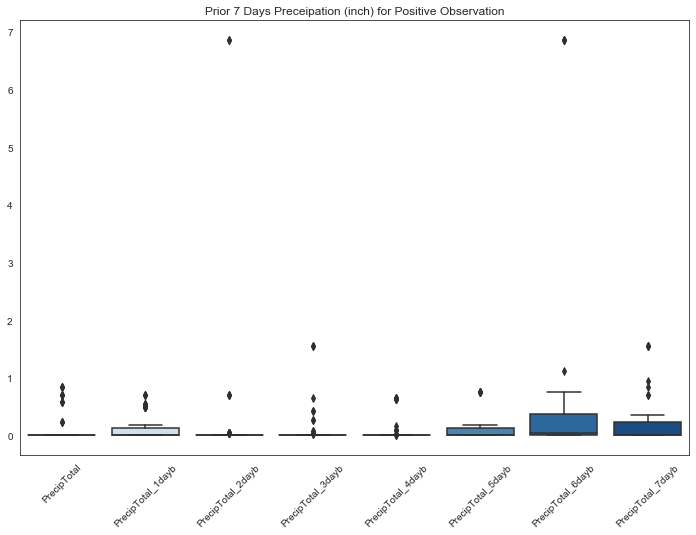

In [118]:
draw_boxplot(df_t900[df_t900['WnvPresent']==1][precip_cols], 
             'Prior 7 Days Preceipation (inch) for Positive Observation')

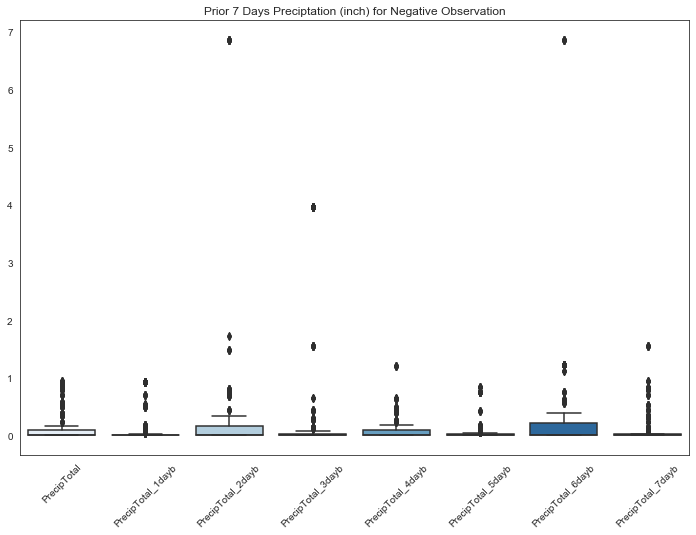

In [119]:
draw_boxplot(df_t900[df_t900['WnvPresent']==0][precip_cols], 
             'Prior 7 Days Preciptation (inch) for Negative Observation')

We observed that there are consecutive PrecipTotal on day 5/6/7 for the positive observations (WnvPresent). We could infer that this may be a cause for mosquitos breeding due to higher amount of rain. These may be good predictors for our prediction model.

### DewPoint Column

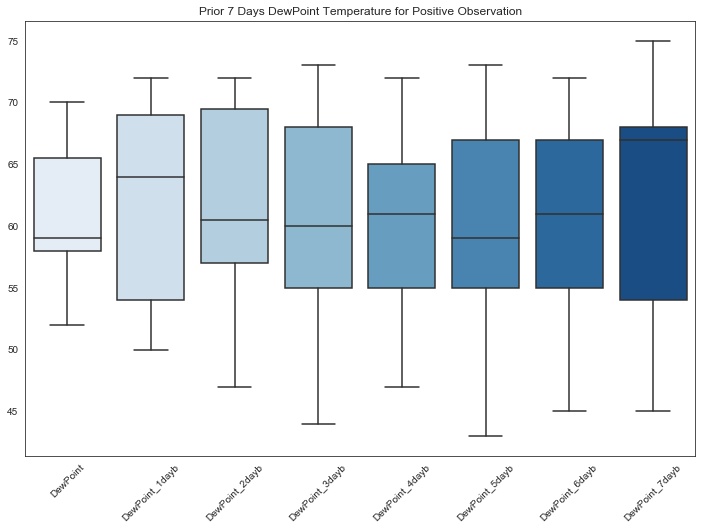

In [120]:
#Positive Observations
draw_boxplot(df_t900[df_t900['WnvPresent']==1][dewpoint_cols], 
             'Prior 7 Days DewPoint Temperature for Positive Observation')

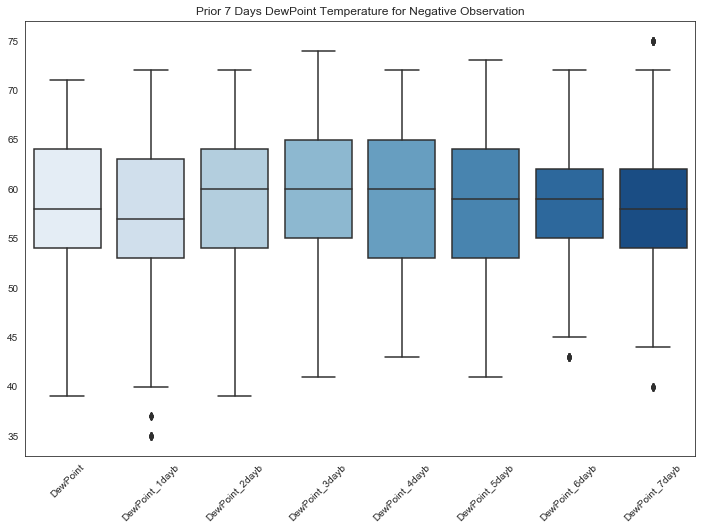

In [121]:
#Negative Observations
draw_boxplot(df_t900[df_t900['WnvPresent']==0][dewpoint_cols], 
             'Prior 7 Days DewPoint Temperature for Negative Observation')

We observed that DewPoint temperature on 1 day prior and 7 days prior is much higher for the positive observations 
(WnvPresent). We could infer that this may be a cause for mosquitos breeding due to higher level of humidity in the air.
We could also infer that both may be good predictors for our prediction model.

### Average Temperature Column

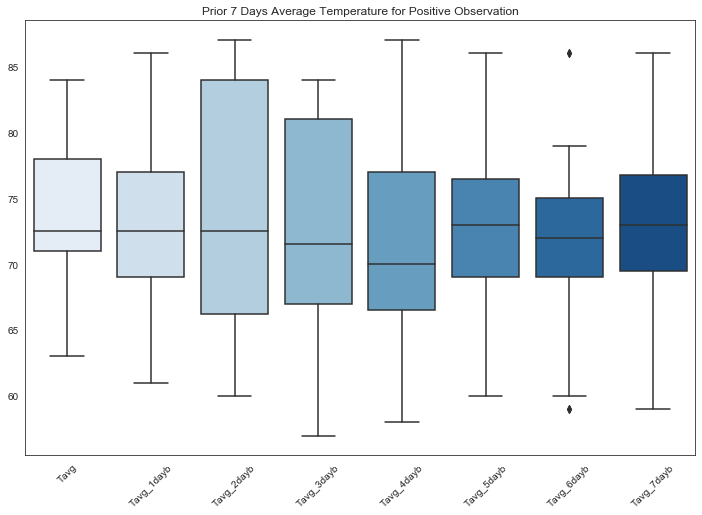

In [122]:
#Positive Observations
draw_boxplot(df_t900[df_t900['WnvPresent']==1][tavg_cols], 
             'Prior 7 Days Average Temperature for Positive Observation')

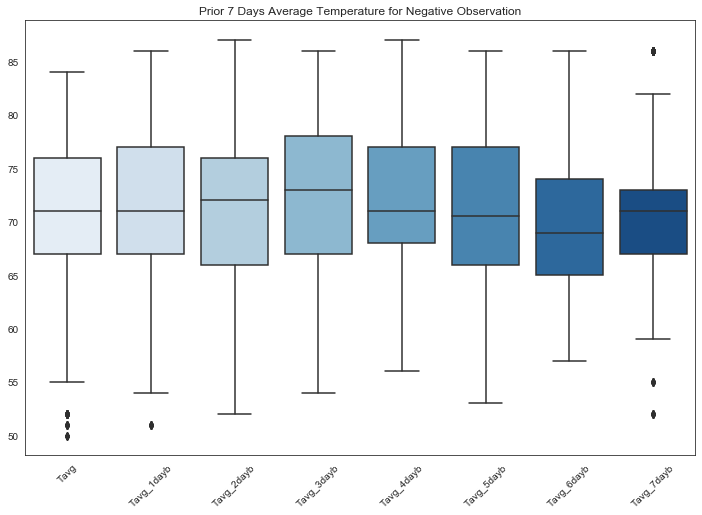

In [123]:
#Negative Observations
draw_boxplot(df_t900[df_t900['WnvPresent']==0][tavg_cols], 
             'Prior 7 Days Average Temperature for Negative Observation')

We observed that the data is similar for both positive and negative observations.

### WetBulb Column

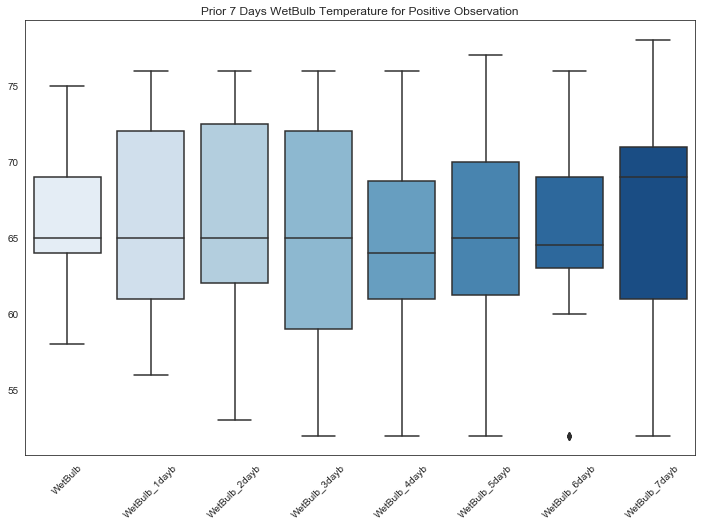

In [124]:
#Positive Observations
draw_boxplot(df_t900[df_t900['WnvPresent']==1][twetb_cols], 
             'Prior 7 Days WetBulb Temperature for Positive Observation')

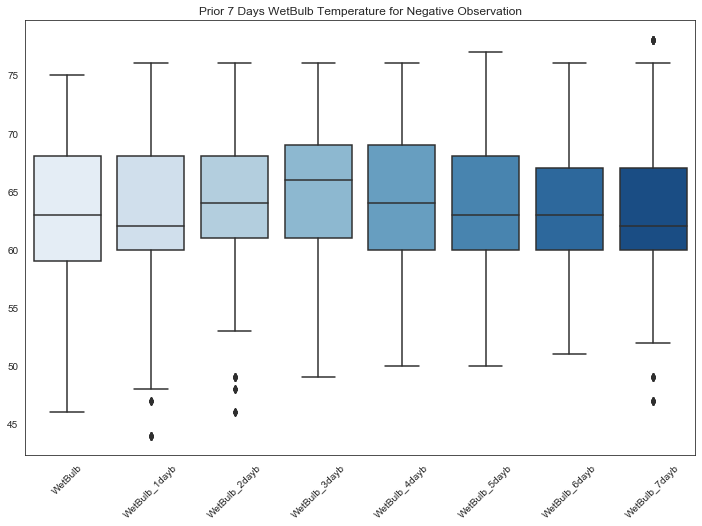

In [125]:
#Negative Observations
draw_boxplot(df_t900[df_t900['WnvPresent']==0][twetb_cols], 
             'Prior 7 Days WetBulb Temperature for Negative Observation')

We observed that WetBulb temperature on the 7 days prior is much higher for the positive observations (WnvPresent). We could infer that this may be a cause for mosquitos breeding due to higher level of humidity in the air. We could infer that this may be a good predictors for our prediction model.

## Feature Engineering

In this section, we will be creating new features. Based on the investigations on hotspot analysis, we will create the prior 7 days weather readings for our training and test data for modeling.

### Prior 7 days weather reading columns on PrecipTotal, Tavg, DewPoint, WetBulb

In [126]:
#join train_weather data with df_7days on date/station to create 7 days reading columns
df_train_weather = pd.merge(df_train_weather, df_7days, how='left', on=['Date','Station'])

In [127]:
#join test_weather data with df_7days on date/station to create 7 days reading columns
df_test_weather = pd.merge(df_test_weather, df_7days, how='left', on=['Date','Station'])

In [128]:
df_train_weather.columns

Index(['Date', 'Address', 'Species', 'Trap', 'Latitude', 'Longitude',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Station', 'Tmax',
       'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'Sunrise', 'Sunset', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'DewPointDepression', 'WetBulbDepression', 'RelativeHumidity', 'Sign',
       'FU', 'HZ', 'RA', 'VCTS', 'SN', 'No', 'DZ', 'VCFG', 'FG+', 'BR', 'TSRA',
       'MIFG', 'FG', 'TS', 'GR', 'BCFG', 'SQ', 'Year', 'Month', 'Week', 'Day',
       'PrecipTotal_1dayb', 'PrecipTotal_2dayb', 'PrecipTotal_3dayb',
       'PrecipTotal_4dayb', 'PrecipTotal_5dayb', 'PrecipTotal_6dayb',
       'PrecipTotal_7dayb', 'DewPoint_1dayb', 'DewPoint_2dayb',
       'DewPoint_3dayb', 'DewPoint_4dayb', 'DewPoint_5dayb', 'DewPoint_6dayb',
       'DewPoint_7dayb', 'Tavg_1dayb', 'Tavg_2dayb', 'Tavg_3dayb',
       'Tavg_4dayb', 'Tavg_5dayb', 'Tavg_6dayb',

In [129]:
df_train_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 82 columns):
Date                  10506 non-null datetime64[ns]
Address               10506 non-null object
Species               10506 non-null object
Trap                  10506 non-null object
Latitude              10506 non-null float64
Longitude             10506 non-null float64
AddressAccuracy       10506 non-null int64
NumMosquitos          10506 non-null int64
WnvPresent            10506 non-null int64
Station               10506 non-null int32
Tmax                  10506 non-null int64
Tmin                  10506 non-null int64
Tavg                  10506 non-null int32
Depart                10506 non-null int32
DewPoint              10506 non-null int64
WetBulb               10506 non-null int32
Heat                  10506 non-null int32
Cool                  10506 non-null int32
Sunrise               10506 non-null object
Sunset                10506 non-null object
Depth        

In [130]:
df_test_weather.columns

Index(['Id', 'Date', 'Address', 'Species', 'Trap', 'Latitude', 'Longitude',
       'AddressAccuracy', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'DewPointDepression',
       'WetBulbDepression', 'RelativeHumidity', 'Sign', 'FU', 'HZ', 'RA',
       'VCTS', 'SN', 'No', 'DZ', 'VCFG', 'FG+', 'BR', 'TSRA', 'MIFG', 'FG',
       'TS', 'GR', 'BCFG', 'SQ', 'Year', 'Month', 'Week', 'Day',
       'PrecipTotal_1dayb', 'PrecipTotal_2dayb', 'PrecipTotal_3dayb',
       'PrecipTotal_4dayb', 'PrecipTotal_5dayb', 'PrecipTotal_6dayb',
       'PrecipTotal_7dayb', 'DewPoint_1dayb', 'DewPoint_2dayb',
       'DewPoint_3dayb', 'DewPoint_4dayb', 'DewPoint_5dayb', 'DewPoint_6dayb',
       'DewPoint_7dayb', 'Tavg_1dayb', 'Tavg_2dayb', 'Tavg_3dayb',
       'Tavg_4dayb', 'Tavg_5dayb', 'Tavg_6dayb', 'Tavg_7dayb', 'WetBulb_

In [131]:
# Create LongLat column based on multiplication of Latitude and Longitude [Latitude, Longitude to be dropped]
df_train_weather['LongLat'] = df_train_weather['Latitude']*df_train_weather['Longitude']
df_test_weather['LongLat'] = df_test_weather['Latitude']*df_test_weather['Longitude']

#df_train_weather.drop(['Latitude','Longitude'],axis=1,inplace=True)
#df_test_weather.drop(['Latitude','Longitude'],axis=1,inplace=True)

In [132]:
#Check after new feature creation. Show first 8 entries of the new feature created 
print("LogLat Train:\n", df_train_weather.LongLat.unique()[:8])
print("LogLat Test :\n", df_test_weather.LongLat.unique()[:8])

LogLat Train:
 [-3683.6633591  -3685.87008168 -3686.3664753  -3675.11805993
 -3671.94462571 -3669.82886286 -3672.42831865 -3676.08572215]
LogLat Test :
 [-3683.6633591  -3685.87008168 -3686.3664753  -3675.11805993
 -3671.94462571 -3669.82886286 -3672.42831865 -3676.08572215]


In [133]:
#Change data type for Sunrise and Sunset to make it easier for model (e.g  XGB error)

df_train_weather['Sunrise'] = df_train_weather['Sunrise'].astype(int)
df_train_weather['Sunset']  = df_train_weather['Sunset'].astype(int)

df_test_weather['Sunrise'] = df_test_weather['Sunrise'].astype(int)
df_test_weather['Sunset']  = df_test_weather['Sunset'].astype(int)

In [134]:
#Check after changing datatype of the feature. Show first 10 entries of the modified feature
print("Sunrise Train: ", df_train_weather.Sunrise.unique()[:10])
print("Sunset  Train: ", df_train_weather.Sunset.unique()[:10])

print("Sunrise Test : ", df_test_weather.Sunrise.unique()[:10])
print("Sunset  Test : ", df_test_weather.Sunset.unique()[:10])

Sunrise Train:  [421 417 418 419 420 426 432 433 438 440]
Sunset  Train:  [1917 1923 1931 1928 1924 1918 1911 1910 1909 1904]
Sunrise Test :  [416 417 420 422 426 428 434 436 437 441]
Sunset  Test :  [1926 1929 1931 1930 1928 1927 1922 1920 1919 1916]


In [135]:
df_train_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 83 columns):
Date                  10506 non-null datetime64[ns]
Address               10506 non-null object
Species               10506 non-null object
Trap                  10506 non-null object
Latitude              10506 non-null float64
Longitude             10506 non-null float64
AddressAccuracy       10506 non-null int64
NumMosquitos          10506 non-null int64
WnvPresent            10506 non-null int64
Station               10506 non-null int32
Tmax                  10506 non-null int64
Tmin                  10506 non-null int64
Tavg                  10506 non-null int32
Depart                10506 non-null int32
DewPoint              10506 non-null int64
WetBulb               10506 non-null int32
Heat                  10506 non-null int32
Cool                  10506 non-null int32
Sunrise               10506 non-null int32
Sunset                10506 non-null int32
Depth          

In [136]:
df_test_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 82 columns):
Id                    116293 non-null int64
Date                  116293 non-null datetime64[ns]
Address               116293 non-null object
Species               116293 non-null object
Trap                  116293 non-null object
Latitude              116293 non-null float64
Longitude             116293 non-null float64
AddressAccuracy       116293 non-null int64
Station               116293 non-null int32
Tmax                  116293 non-null int64
Tmin                  116293 non-null int64
Tavg                  116293 non-null int32
Depart                116293 non-null int32
DewPoint              116293 non-null int64
WetBulb               116293 non-null int32
Heat                  116293 non-null int32
Cool                  116293 non-null int32
Sunrise               116293 non-null int32
Sunset                116293 non-null int32
Depth                 116293 non-null

### Handling of important Categorical features Species and Trap

Merge two dataframes as the catgeorical features are present in both. Perform Encoding and split dataframes again

Create columns to differentiate between train and test, merged the dataframe and performed one hot encoding for Species and Trap. After the one hot encoding is performed, we dropped the created columns and separate the dataframe.

In [137]:
#Before one-hot encoding for train_final, test_final, need to merge them first
print(df_train_weather.shape, df_test_weather.shape)

df_train_weather['is_train']  = 1
df_test_weather['is_train']   = 0

df_train_weather['Id']        = 0
df_test_weather['WnvPresent'] = 9

df_train_weather.shape, df_test_weather.shape

(10506, 83) (116293, 82)


((10506, 85), (116293, 84))

In [138]:
#rearrange the column order in both train and test before merge them for one-hot encoding
list_columns_train = df_train_weather.columns
list_columns_test  = df_test_weather.columns
df_train_weather   = df_train_weather.reindex(columns=list_columns_train)
df_test_weather    = df_test_weather.reindex(columns=list_columns_test)
df_train_weather.shape, df_test_weather.shape

((10506, 85), (116293, 84))

In [139]:
#one-hot encoding for df_train_weather, df_test_weather. Merge them
df_combined   = pd.concat([df_train_weather, df_test_weather],axis=0, sort=False)
df_combined.shape

(126799, 85)

In [140]:
#perform one-hot encoding
object_columns = ['Species', 'Trap']

df_combined = pd.get_dummies(df_combined, columns = object_columns, drop_first = False)
print(df_combined.shape)

#Remove duplicated columns (if any) from the combined dataframe
df_combined = df_combined.loc[:,~df_combined.columns.duplicated()]
df_combined.shape

(126799, 240)


(126799, 240)

In [141]:
#split the combined set into respective train and test datasets with same names as before merging
df_train_weather = df_combined[df_combined['is_train'] == 1]
df_test_weather  = df_combined[df_combined['is_train']  == 0]
df_train_weather.shape, df_test_weather.shape

((10506, 240), (116293, 240))

In [142]:
#drop columns created previously for merging to do one-hot encoding
df_train_weather = df_train_weather.drop(['Id', 'is_train'],       axis=1)
df_test_weather  = df_test_weather.drop(['WnvPresent', 'is_train'],axis=1)
df_train_weather.shape, df_test_weather.shape

((10506, 238), (116293, 238))

In [143]:
df_train_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Columns: 238 entries, Date to Trap_T903
dtypes: datetime64[ns](1), float64(38), int32(10), int64(31), object(1), uint8(157)
memory usage: 7.7+ MB


In [144]:
df_test_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Columns: 238 entries, Date to Trap_T903
dtypes: datetime64[ns](1), float64(38), int32(10), int64(31), object(1), uint8(157)
memory usage: 85.7+ MB


In [145]:
# Save Processed Train/Test dataset without dropping any column for cost benefit analysis. Used pickle files as orginal source files are csv. 
df_train_weather.to_pickle('../assets/train_processed.pkl')
df_test_weather.to_pickle('../assets/test_processed.pkl')

In [146]:
pd.options.display.max_seq_items = None

In [147]:
df_train_weather.columns

Index(['Date', 'Address', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Station', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'DewPointDepression',
       'WetBulbDepression', 'RelativeHumidity', 'Sign', 'FU', 'HZ', 'RA',
       'VCTS', 'SN', 'No', 'DZ', 'VCFG', 'FG+', 'BR', 'TSRA', 'MIFG', 'FG',
       'TS', 'GR', 'BCFG', 'SQ', 'Year', 'Month', 'Week', 'Day',
       'PrecipTotal_1dayb', 'PrecipTotal_2dayb', 'PrecipTotal_3dayb',
       'PrecipTotal_4dayb', 'PrecipTotal_5dayb', 'PrecipTotal_6dayb',
       'PrecipTotal_7dayb', 'DewPoint_1dayb', 'DewPoint_2dayb',
       'DewPoint_3dayb', 'DewPoint_4dayb', 'DewPoint_5dayb', 'DewPoint_6dayb',
       'DewPoint_7dayb', 'Tavg_1dayb', 'Tavg_2dayb', 'Tavg_3dayb',
       'Tavg_4dayb', 'Tavg_5dayb', 'Tavg_6dayb', 'Tavg_7dayb', 'Wet

In [148]:
df_test_weather.columns

Index(['Date', 'Address', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'Water1',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'DewPointDepression', 'WetBulbDepression',
       'RelativeHumidity', 'Sign', 'FU', 'HZ', 'RA', 'VCTS', 'SN', 'No', 'DZ',
       'VCFG', 'FG+', 'BR', 'TSRA', 'MIFG', 'FG', 'TS', 'GR', 'BCFG', 'SQ',
       'Year', 'Month', 'Week', 'Day', 'PrecipTotal_1dayb',
       'PrecipTotal_2dayb', 'PrecipTotal_3dayb', 'PrecipTotal_4dayb',
       'PrecipTotal_5dayb', 'PrecipTotal_6dayb', 'PrecipTotal_7dayb',
       'DewPoint_1dayb', 'DewPoint_2dayb', 'DewPoint_3dayb', 'DewPoint_4dayb',
       'DewPoint_5dayb', 'DewPoint_6dayb', 'DewPoint_7dayb', 'Tavg_1dayb',
       'Tavg_2dayb', 'Tavg_3dayb', 'Tavg_4dayb', 'Tavg_5dayb', 'Tavg_6dayb',
       'Tavg_7dayb', 'WetBulb_1dayb', '

In [149]:
# Finding top 75 correlated columns (with correlation score of around 0.020 or higher)
corr_matrix = df_train_weather.corr()
columns = round(abs(corr_matrix['WnvPresent']).sort_values(ascending=False).head(76),2)
columns

WnvPresent                  1.00
NumMosquitos                0.20
DewPoint_1dayb              0.12
Sunrise                     0.11
Week                        0.10
WetBulb_1dayb               0.10
Month                       0.10
Species_CULEX PIPIENS       0.10
Species_CULEX RESTUANS      0.09
DewPoint_7dayb              0.09
DewPoint_2dayb              0.09
WetBulb_2dayb               0.09
DewPoint                    0.08
WetBulb_7dayb               0.08
WetBulb                     0.08
Tavg_1dayb                  0.07
Sunset                      0.07
DewPoint_6dayb              0.07
Tavg_2dayb                  0.07
Tmin                        0.07
WetBulb_6dayb               0.07
Tavg_7dayb                  0.06
FG                          0.06
BR                          0.06
Longitude                   0.06
Tavg                        0.06
Station                     0.06
PrecipTotal_1dayb           0.06
RelativeHumidity            0.06
Depart                      0.06
DewPoint_3

In [150]:
columns = round(abs(corr_matrix['WnvPresent']).sort_values(ascending=False).tail(50),2)
columns

Trap_T035                    0.0
Trap_T237                    0.0
Trap_T232                    0.0
Trap_T089                    0.0
Trap_T160                    0.0
PrecipTotal_4dayb            0.0
Trap_T090                    0.0
Trap_T040                    0.0
Trap_T065                    0.0
Trap_T084                    0.0
Trap_T036                    0.0
Species_CULEX ERRATICUS      0.0
Tavg_4dayb                   0.0
Trap_T095                    0.0
ResultDir                    0.0
Trap_T138                    0.0
Trap_T097                    0.0
Trap_T156                    0.0
Trap_T162                    0.0
Trap_T039                    0.0
Trap_T142                    0.0
Trap_T227                    0.0
Trap_T033                    0.0
Trap_T066                    0.0
Trap_T226                    0.0
Depth                        NaN
Water1                       NaN
SnowFall                     NaN
FU                           NaN
SN                           NaN
VCFG      

In [151]:
columns = round(abs(corr_matrix['WnvPresent']).sort_index(ascending=True).head(15),2)
columns

AddressAccuracy       0.01
AvgSpeed              0.03
BCFG                   NaN
BR                    0.06
Cool                  0.05
DZ                    0.01
Day                   0.01
Depart                0.06
Depth                  NaN
DewPoint              0.08
DewPointDepression    0.05
DewPoint_1dayb        0.12
DewPoint_2dayb        0.09
DewPoint_3dayb        0.05
DewPoint_4dayb        0.03
Name: WnvPresent, dtype: float64

We will be dropping columns which are confirmed to have no explainable variance. For remaining features the selection will be done during as part of preparation prior to modelling

In [152]:
train_cols_to_drop = ['NumMosquitos',
                    'Depth', 
                    'Water1', 
                    'SnowFall',
                    'Date', 
                    'Week',
                    'Day',
                    'Address',
                    'AddressAccuracy',
                    'Latitude',
                    'Longitude'
                     ]

df_train_weather.drop(train_cols_to_drop, axis=1, inplace=True)

test_cols_to_drop = ['NumMosquitos',
                    'Depth', 
                    'Water1', 
                    'SnowFall',
                    'Date', 
                    'Week',
                    'Day',
                    'Address',
                    'AddressAccuracy',
                    'Latitude',
                    'Longitude'
                    ]

df_test_weather.drop(test_cols_to_drop, axis=1, inplace=True)

In [153]:
df_train_weather.shape, df_test_weather.shape

((10506, 227), (116293, 227))

In [154]:
df_train_weather.WnvPresent.value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [155]:
df_train_weather.WnvPresent.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

###  Oversampling to Balance the Dataset

In [156]:
#df_train_weather.WnvPresent.value_counts(normalize=True)

As our target is not balanced, we will need to do oversampling to balance the data

- use over-sample to increase the samples for negative class
- References used
    - https://imbalanced-learn.org/stable/api.html   
    - https://pythonhealthcare.org/2019/04/12/122-oversampling-to-correct-for-imbalanced-data-using-naive-sampling-or-smote/
- https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb


- conda install -c conda-forge imbalanced-learn
    - from imblearn import under_sampling, over_sampling
    - from imblearn.over_sampling import SMOTE

In [157]:
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
train_X_os, train_y_os = sm.fit_sample(df_train_weather.drop('WnvPresent',axis=1),df_train_weather['WnvPresent'])
df_train_weather_os = pd.concat([pd.DataFrame(train_y_os), pd.DataFrame(train_X_os)], axis=1)
df_train_weather_os.columns = df_train_weather.columns

print(df_train_weather_os.shape)
print(df_train_weather_os['WnvPresent'].value_counts())
df_train_weather_os['WnvPresent'].value_counts(normalize=True)

(19910, 227)
1    9955
0    9955
Name: WnvPresent, dtype: int64


1    0.5
0    0.5
Name: WnvPresent, dtype: float64

In [158]:
#Columns/Features in train dataset and balanced train(train_oversampled) are same
set(df_train_weather) - set(df_train_weather_os)

set()

In [159]:
set(df_train_weather_os) - set(df_train_weather)

set()

In [160]:
#Check Columns/Features in train dataset that are not available in test dataset
set(df_train_weather) - set(df_test_weather)

{'WnvPresent'}

In [161]:
set(df_train_weather_os) - set(df_test_weather)

{'WnvPresent'}

In [162]:
#Columns/Features in test dataset that are not available in train dataset
set(df_test_weather) - set(df_train_weather)

{'Id'}

In [163]:
set(df_test_weather) - set(df_train_weather_os)

{'Id'}

In [164]:
# Save Processed Train and Test datasets for further analysis. Used pickle files as orginal source files are csv. 
df_test_weather.to_pickle('../assets/test_final.pkl')
df_train_weather.to_pickle('../assets/train_final_unbalanced.pkl')
df_train_weather_os.to_pickle('../assets/train_final.pkl')

As the number of features shortlisted is quite big, we Use PCA to get an idea of recommended number of features

In [165]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
pca = PCA(n_components = None, tol = 0.0)

In [166]:
df_features = df_train_weather_os.drop('WnvPresent',axis=1)
features_ss = ss.fit_transform(df_features)
features_ss_pca = pca.fit_transform(features_ss)

# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 20 components): {np.round(var_exp[:120],3)}')
print('')
# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp[:120],3)}')

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [df_features.columns]
most_important_names[0][42]


Explained variance (first 20 components): [0.076 0.039 0.028 0.023 0.017 0.015 0.012 0.01  0.008 0.008 0.008 0.007
 0.007 0.006 0.006 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005]

Cumulative explained variance (first 20 components): [0.076 0.115 0.143 0.167 0.183 0.198 0.21  0.219 0.228 0.236 0.244 0.251
 0.257 0.264 0.27  0.276 0.281 0.287 0.292 0.297 0.303 0.308 0.313 0.318
 0.323 0.328 0.333 0.338 0.

'PrecipTotal_3dayb'

In [167]:
# print pca and feature names
pca_feature = list(zip(most_important, most_important_names[0][most_important],var_exp))
print(len(pca_feature))
pca_feature

226


[(61, 'WetBulb_1dayb', 0.07616228244867622),
 (20, 'Sign', 0.03923335300843105),
 (18, 'WetBulbDepression', 0.02797095298614992),
 (63, 'WetBulb_3dayb', 0.023198511781016545),
 (9, 'Sunrise', 0.016516291563067477),
 (68, 'LongLat', 0.014609752353499823),
 (44, 'PrecipTotal_5dayb', 0.012010091077522227),
 (48, 'DewPoint_2dayb', 0.009796531473718057),
 (40, 'PrecipTotal_1dayb', 0.008209740249980542),
 (43, 'PrecipTotal_4dayb', 0.00799740350351604),
 (14, 'ResultSpeed', 0.00781881381763962),
 (71, 'Species_CULEX PIPIENS/RESTUANS', 0.007084387493019613),
 (71, 'Species_CULEX PIPIENS/RESTUANS', 0.006772226869287864),
 (41, 'PrecipTotal_2dayb', 0.0063438701386631805),
 (46, 'PrecipTotal_7dayb', 0.005970514739727703),
 (75, 'Species_CULEX TERRITANS', 0.005826527545276536),
 (165, 'Trap_T115', 0.00573444441108349),
 (73, 'Species_CULEX SALINARIUS', 0.005461521587488092),
 (73, 'Species_CULEX SALINARIUS', 0.005391604371470423),
 (74, 'Species_CULEX TARSALIS', 0.005333195111218645),
 (224, 'Trap

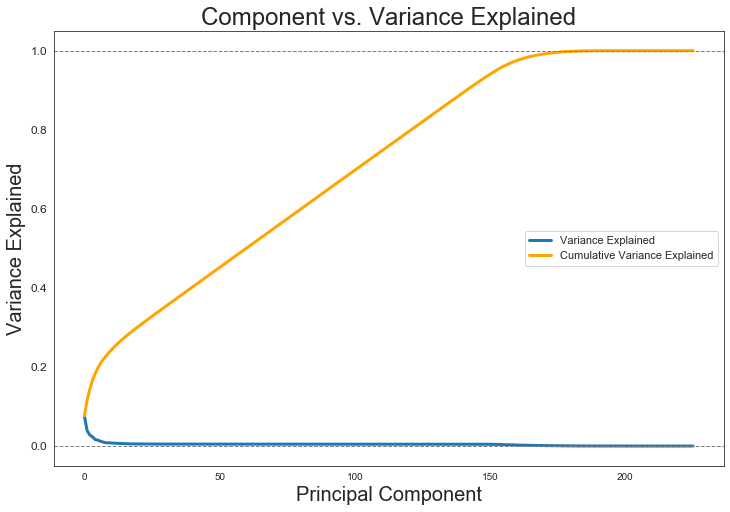

In [168]:
# Plot the variance explained (and cumulative variance explained).
# Set figure size.
plt.figure(figsize=(12,8))
# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')
# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')
# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')
# Set the limits of the axes.
#plt.xlim([-1,21])
#plt.ylim([-0.01,1.01])
# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)
# Make the tick labels bigger
#plt.xticks(range(0, 21, 5), range(1, 22, 5), fontsize=12)
plt.yticks(fontsize=12)
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

For 50 top Features the commulative variance explained is about 40%
To use PCA, we will need to use around 125 features (the commulative variance explained > 80%)